In [9]:
import pandas as pd
import numpy as np
import pickle
import gc
import seaborn as sns
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import itertools

# 1. Data Loading

## 1.1. Загрузка и обработка датасета с целевой переменной.

Предварительный анализ данных показал, что целевая переменная находится в датасете ga_hits.csv загрузим его.

In [10]:
hits = pd.read_csv('ga_hits.csv')
print(hits.shape)
hits.head()

(15726470, 11)


,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


Проверим датасет на наличие пропусков

In [11]:
hits.isna().sum()

session_id               0
hit_date                 0
hit_time           9160322
hit_number               0
hit_type                 0
hit_referer        6274804
hit_page_path            0
event_category           0
event_action             0
event_label        3760184
event_value       15726470
dtype: int64

В этом датасете нас будет интерисовать две колонки session_id и event_category. По условию задачи целевой переменной будет 
наличие определенных действий, которые отражены в колонке event_category в зависимости от номера сессии. Пусть 1 будет наличие
целевоого действия за сессию, а 0 отсутствие. на основании этого выделим целевую переменную из датасета.

In [12]:
targets = ['sub_car_claim_click', 'sub_car_claim_submit_click',
'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click']
hits['target'] = hits.event_action.apply(lambda x: 1 if x in targets else 0)
hits = hits[['session_id', 'target']].groupby(by=['session_id']).max().reset_index()
hits.head()

,session_id,target
0,1000009318903347362.1632663668.1632663668,0
1,1000010177899156286.1635013443.1635013443,0
2,1000013386240115915.1635402956.1635402956,0
3,1000017303238376207.1623489300.1623489300,0
4,1000020580299877109.1624943350.1624943350,0


## 1.2. Загрузка основного датасета и добавление к нему целевой переменной

In [13]:
sess = pd.read_csv('ga_sessions.csv', low_memory=False)
print(sess.shape)
sess.head()

(1860042, 18)


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [14]:
sess = sess.merge(hits, how='left')
sess

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0.0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0.0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0.0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0.0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,VlqBmecIOXWjCWUmQkLd,desktop,Windows,NaN,NaN,1920x1080,Chrome,Russia,Moscow,0.0
1860038,9055421130527858185.1622007305.1622007305,2108379530.1622007305,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,390x844,Safari,Russia,Stavropol,0.0
1860039,9055422955903931195.1636979515.1636979515,2108379955.1636979515,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,375x667,Safari,Russia,Moscow,0.0
1860040,905543020766873816.1638189404.1638189404,210838164.1638189272,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,NaN,393x851,Chrome,Russia,Chelyabinsk,0.0


Очистим память от датасета hits

In [15]:
del hits
gc.collect()

0

# 2. Data Preparation

## 2.1. Data Formalization

Выведем информацию о датасете

In [16]:
sess.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1860042 entries, 0 to 1860041
Data columns (total 19 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   session_id                object 
 1   client_id                 object 
 2   visit_date                object 
 3   visit_time                object 
 4   visit_number              int64  
 5   utm_source                object 
 6   utm_medium                object 
 7   utm_campaign              object 
 8   utm_adcontent             object 
 9   utm_keyword               object 
 10  device_category           object 
 11  device_os                 object 
 12  device_brand              object 
 13  device_model              object 
 14  device_screen_resolution  object 
 15  device_browser            object 
 16  geo_country               object 
 17  geo_city                  object 
 18  target                    float64
dtypes: float64(1), int64(1), object(17)
memory usage: 283.8+ MB


In [17]:
sess.columns

Index(['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number',
       'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_model', 'device_screen_resolution', 'device_browser',
       'geo_country', 'geo_city', 'target'],
      dtype='object')

Выведем информацию о пропусках в итоговом датасете в %

In [18]:
sess.isna().sum() * 100 / len(sess)

session_id                   0.000000
client_id                    0.000000
visit_date                   0.000000
visit_time                   0.000000
visit_number                 0.000000
utm_source                   0.005215
utm_medium                   0.000000
utm_campaign                11.806346
utm_adcontent               18.043410
utm_keyword                 58.174009
device_category              0.000000
device_os                   57.533002
device_brand                19.740307
device_model                99.121633
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
target                       6.869522
dtype: float64

Из приведенной выше информации можно заметить, что часть строк не содержат информацию о целевой переменной - их нужно 
иссключить.

In [19]:
sess = sess[sess.target.isna() == 0]

Сохраним датасет в файл для использования в пайплайне

In [20]:
sess.to_csv('sess.csv', index=False)

Посмотрим какие значения принимают переменные с характеристиками.

In [12]:
col = sess.columns
for i in col:
    print(f'Характеристика: {i}')
    print(f'Количество уникальных значений:{len(sess[i].unique())}')
    print(f'Список значений:\n {sess[i].value_counts()}\n')

Характеристика: session_id
Количество уникальных значений:1732266
Список значений:
 9055434745589932991.1637753792.1637753792    1
629529258169981545.1626332167.1626332167     1
6295352713792576176.1634065074.1634065074    1
6295350622136026841.1626588901.1626588901    1
6295349887709233242.1639202906.1639202906    1
                                            ..
3524000133754500026.1625142208.1625142208    1
3523993785803856201.1636161866.1636161866    1
352398731068897298.1621686290.1621686290     1
3523985479341028705.1640084833.1640084833    1
9055430416266113553.1640968742.1640968742    1
Name: session_id, Length: 1732266, dtype: int64

Характеристика: client_id
Количество уникальных значений:1320704
Список значений:
 1750498477.1629450062    449
1266574870.1623140118    303
736859557.1619557452     301
1894772482.1621860860    270
1065181919.1631610625    256
                        ... 
876013814.1640977660       1
87601347.1639682886        1
87601005.1630928998        1
876006

Список значений:
 Moscow              750928
Saint Petersburg    278402
(not set)            73297
Yekaterinburg        33555
Krasnodar            30260
                     ...  
Oldbury                  1
Bad Breisig              1
Ilza                     1
Svishtov                 1
Compiegne                1
Name: geo_city, Length: 2389, dtype: int64

Характеристика: target
Количество уникальных значений:2
Список значений:
 0.0    1681952
1.0      50314
Name: target, dtype: int64



Целевой переменной является target. Визуализируем ее распределение.

Histogram for target


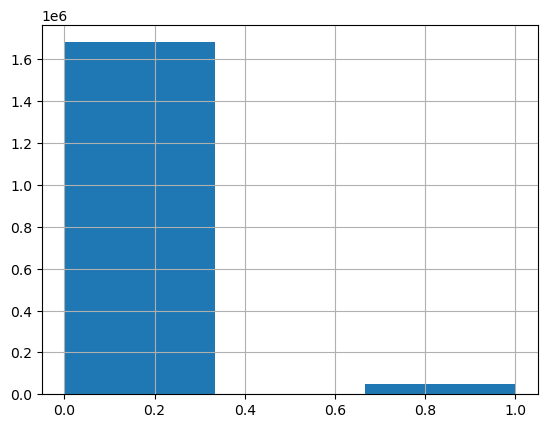

In [13]:
print(f'Histogram for target')
sess['target'].hist(bins=3)
plt.show()

Из графика выше можно увидеть сильную разбалансировку классов. Конверсия будет составлять (%):

In [14]:
round(len(sess[sess.target == 1]) * 100 / len(sess), 1)

2.9

## 2.2. Exploratory Data Analysis. Data Cleaning

### Обработка пропусков

Колонки utm_keyword, device_os, device_model содержат более 50% пропусков - удалим их. Колонки с id сессии и клиента, также не 
несут полезной информации для будущей модели - удалим и их.

In [15]:
sess = sess[['visit_date', 'visit_time', 'visit_number',
       'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'device_category', 'device_brand',
        'device_screen_resolution', 'device_browser',
       'geo_country', 'geo_city', 'target']]
sess

,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
0,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Zlatoust,0.0
1,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Samsung,385x854,Samsung Internet,Russia,Moscow,0.0
2,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0.0
3,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0.0
4,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,desktop,NaN,1920x1080,Chrome,Russia,Moscow,0.0
1860038,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,390x844,Safari,Russia,Stavropol,0.0
1860039,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,375x667,Safari,Russia,Moscow,0.0
1860040,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Xiaomi,393x851,Chrome,Russia,Chelyabinsk,0.0


In [16]:
# Выведем количество полностью заполненных объектов и их процент из всей выборки.
full_values = len(sess.dropna())
percent_full = round(full_values * 100 / len(sess), 2)
print(f'Процент полностью заполненных объектов значений: {full_values}, их процент составляет: {percent_full}%')

Процент полностью заполненных объектов значений: 1150797, их процент составляет: 66.43%


Выведем информацию о пропусках в итоговом датасете в %

In [17]:
sess.isna().sum() * 100 / len(sess)

visit_date                   0.000000
visit_time                   0.000000
visit_number                 0.000000
utm_source                   0.004387
utm_medium                   0.000000
utm_campaign                11.273500
utm_adcontent               17.557177
device_category              0.000000
device_brand                20.042880
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
target                       0.000000
dtype: float64

In [18]:
col = sess.columns
for i in col:
    print(f'Характеристика: {i}')
    print(f'Количество уникальных значений:{len(sess[i].unique())}')
    print(f'Список значений:\n {sess[i].value_counts()}\n')

Характеристика: visit_date
Количество уникальных значений:226
Список значений:
 2021-05-24    39230
2021-12-21    29864
2021-05-25    19160
2021-06-29    16887
2021-09-14    15583
              ...  
2021-06-05     2032
2021-05-23     1109
2021-05-21      826
2021-05-22      761
2021-05-19      703
Name: visit_date, Length: 226, dtype: int64

Характеристика: visit_time
Количество уникальных значений:85032
Список значений:
 13:00:00    58044
12:00:00    57540
14:00:00    56824
10:00:00    56739
11:00:00    56270
            ...  
05:28:49        1
03:44:30        1
03:36:26        1
03:53:01        1
04:30:09        1
Name: visit_time, Length: 85032, dtype: int64

Характеристика: visit_number
Количество уникальных значений:533
Список значений:
 1      1301099
2       212176
3        71835
4        36600
5        21482
        ...   
418          1
419          1
420          1
421          1
564          1
Name: visit_number, Length: 533, dtype: int64

Характеристика: utm_source
Количес

На основании выше приведенных данных выполним следующее заполнение столбцов: utm_source, utm_campaign - "unknown", device_brand - "(not set)", utm_adcontent - самым частым значением.

In [19]:
imp_const_unknown = SimpleImputer(strategy='constant', fill_value='unknown')
imp_const_notset = SimpleImputer(strategy='constant', fill_value='(not set)')
imp_const_freq = SimpleImputer(strategy='most_frequent')

unk_cols = ['utm_source', 'utm_campaign']
notset_cols = ['device_brand']
freq_cols = ['utm_adcontent']

sess[unk_cols] = imp_const_unknown.fit_transform(sess[unk_cols])
sess[notset_cols] = imp_const_notset.fit_transform(sess[notset_cols])
sess[freq_cols] = imp_const_freq.fit_transform(sess[freq_cols])

full_values = len(sess.dropna())
percent_full = round(full_values * 100 / len(sess), 2)
print(f'Процент полностью заполненных объектов значений: {full_values}, их процент составляет: {percent_full}%')

Процент полностью заполненных объектов значений: 1732266, их процент составляет: 100.0%


### Обработка дат и типов данных, преобразование исходных данных

Колонку visit_date и visit_time преобразуем в формат даты. Из колонки visit_time сразу выделим час.

In [20]:
sess.visit_date = sess.visit_date.astype('datetime64')
sess.visit_time = sess.visit_time.astype('datetime64').dt.hour

Из колонки дата выделим следующие признаки: день, месяц, день недели. Саму дату удалим.

In [21]:
sess['day'] = sess.visit_date.dt.day
sess['day_of_week'] = sess.visit_date.dt.day_of_week
sess['month'] = sess.visit_date.dt.month
sess.drop(columns=['visit_date'], inplace=True)

Разрешение экрана преобразуем в произведение разрешения по горизонтали и вертикали

In [22]:
sess.device_screen_resolution = sess.device_screen_resolution.str.split("x",expand = True).astype('int32').iloc[:,0] * \
sess.device_screen_resolution.str.split("x",expand = True).astype('int32').iloc[:,1]

Преобразование категориальных переменных в тип категории проведем после некотрых дополнительных действий. Уменьшим число 
категорий в некоторых столбцах, чтобы не перегружать будущую модель.

In [23]:
sess.loc[sess['utm_source'].value_counts()[sess['utm_source']].values < 50, 'utm_source'] = 'rare'
sess.loc[sess['utm_campaign'].value_counts()[sess['utm_campaign']].values < 100, 'utm_campaign'] = 'rare'
sess.loc[sess['utm_adcontent'].value_counts()[sess['utm_adcontent']].values < 50, 'utm_adcontent'] = 'rare'
sess.loc[sess['device_brand'].value_counts()[sess['device_brand']].values < 5, 'device_brand'] = 'rare'
sess.loc[sess['utm_medium'].value_counts()[sess['utm_medium']].values < 5, 'utm_medium'] = 'rare'

В колонке device_browser выделим первое слово и проведем некоторые смысловые замены

In [24]:
sess.device_browser = sess.device_browser.str.split(expand = True).iloc[:,0]
sess = sess.replace({'device_browser':{'Mozilla':'Firefox', 'MRCHROME':'Chrome', '(not':'(not set)'}})

В колонках geo_country и geo_city для сокращения категорий заменим значения для которых нет ни одной положительной сессии
на значение other

In [25]:
country = sess.geo_country[sess.target == 1].unique()
city = sess.geo_city[sess.target == 1].unique()


In [26]:
sess.geo_country = sess.geo_country.apply(lambda x: x if x in country else 'other')
sess.geo_city = sess.geo_city.apply(lambda x: x if x in city else 'other')

Преобразуем необходимые нам данные в категориальные

In [27]:
category = ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'device_category', 'device_brand', 'device_browser', 'geo_country', 'geo_city']
sess[category] = sess[category].astype('category')

Изменим тип целевой переменной

In [28]:
sess.target = sess.target.astype('uint8')

### Поиск выбросов

In [29]:
# Для численных переменных найдем есть ли аномальные значения
def calculate_outliers(data, column):
    q25 = data[column].quantile(0.25)
    q75 = data[column].quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)

    return boundaries
for i in sess.describe().columns:
    out = calculate_outliers(sess, i)
    anomaly_count = len(sess[(sess[i] > out[1]) | (sess[i] < out[0])])
    print (f'Количество аномалий в столбце {i}: {anomaly_count}')


Количество аномалий в столбце visit_time: 0
Количество аномалий в столбце visit_number: 431167
Количество аномалий в столбце device_screen_resolution: 361589
Количество аномалий в столбце target: 50314
Количество аномалий в столбце day: 0
Количество аномалий в столбце day_of_week: 0
Количество аномалий в столбце month: 0


In [30]:
sess.visit_number.max()

564

Из информации выше видно, что реальные анамолии встречаются только в столбце visit_number, но аномалиями они не являются, 
тем более этот столбец далее будем преобразовывать.

Разделим датасет на тренировочную и тестовую выборки. Удалим из памяти исходный датасет. Тестовый датасет выведем в файл и также удалим из памяти.

In [31]:
train, test = train_test_split(sess, test_size=0.2, random_state=41)
del sess
test.to_csv('session_test.csv', index=False)
del test
gc.collect()

89

In [32]:
# train.to_csv('session_train.csv', index=False)

In [33]:
# train = pd.read_csv('session_train.csv')
# train

## 2.3. Data Visualization 

### Категориальные переменные

Создадим вспомогатилеьную функцию для построения гистграм распределения категориальных переменных

In [34]:
def grafic(df, column, num):
    
    df_sum = df.groupby([column], as_index=False)[['target']].sum()
    df_count = df.groupby([column], as_index=False)[['target']].count()
    df_count['conversion'] = df_sum.target * 100/ df_count.target
    if df_count.shape[0] > num:
        df_count = df_count.sort_values(by=['target'], ascending=False).iloc[:num,:]
    else:
        df_count = df_count.sort_values(by=['target'], ascending=False).iloc[:df_count.shape[0] + 1,:]
    print('Распределение по кол-ву сессий')
    plt.figure(figsize=(20, 10))
    plt.bar(df_count[column], df_count['target'], color=['springgreen', 'dodgerblue'], width = 0.9)
    plt.xlabel(column)
    plt.ylabel('Количество сессий')
    plt.xticks(rotation = 45)
    plt.title(f'Распределение по {column}');
    plt.show()
    print('Распределение по проценту конверсии')
    plt.figure(figsize=(20, 10))
    plt.bar(df_count[column], df_count['conversion'], color=['springgreen', 'dodgerblue'], width = 0.9)
    plt.xlabel(column)
    plt.ylabel('Конверсия, %')
    plt.xticks(rotation = 45)
    plt.title(f'Распределение по {column}');
    plt.show()

#### Колонка utm_source

Распределение по кол-ву сессий


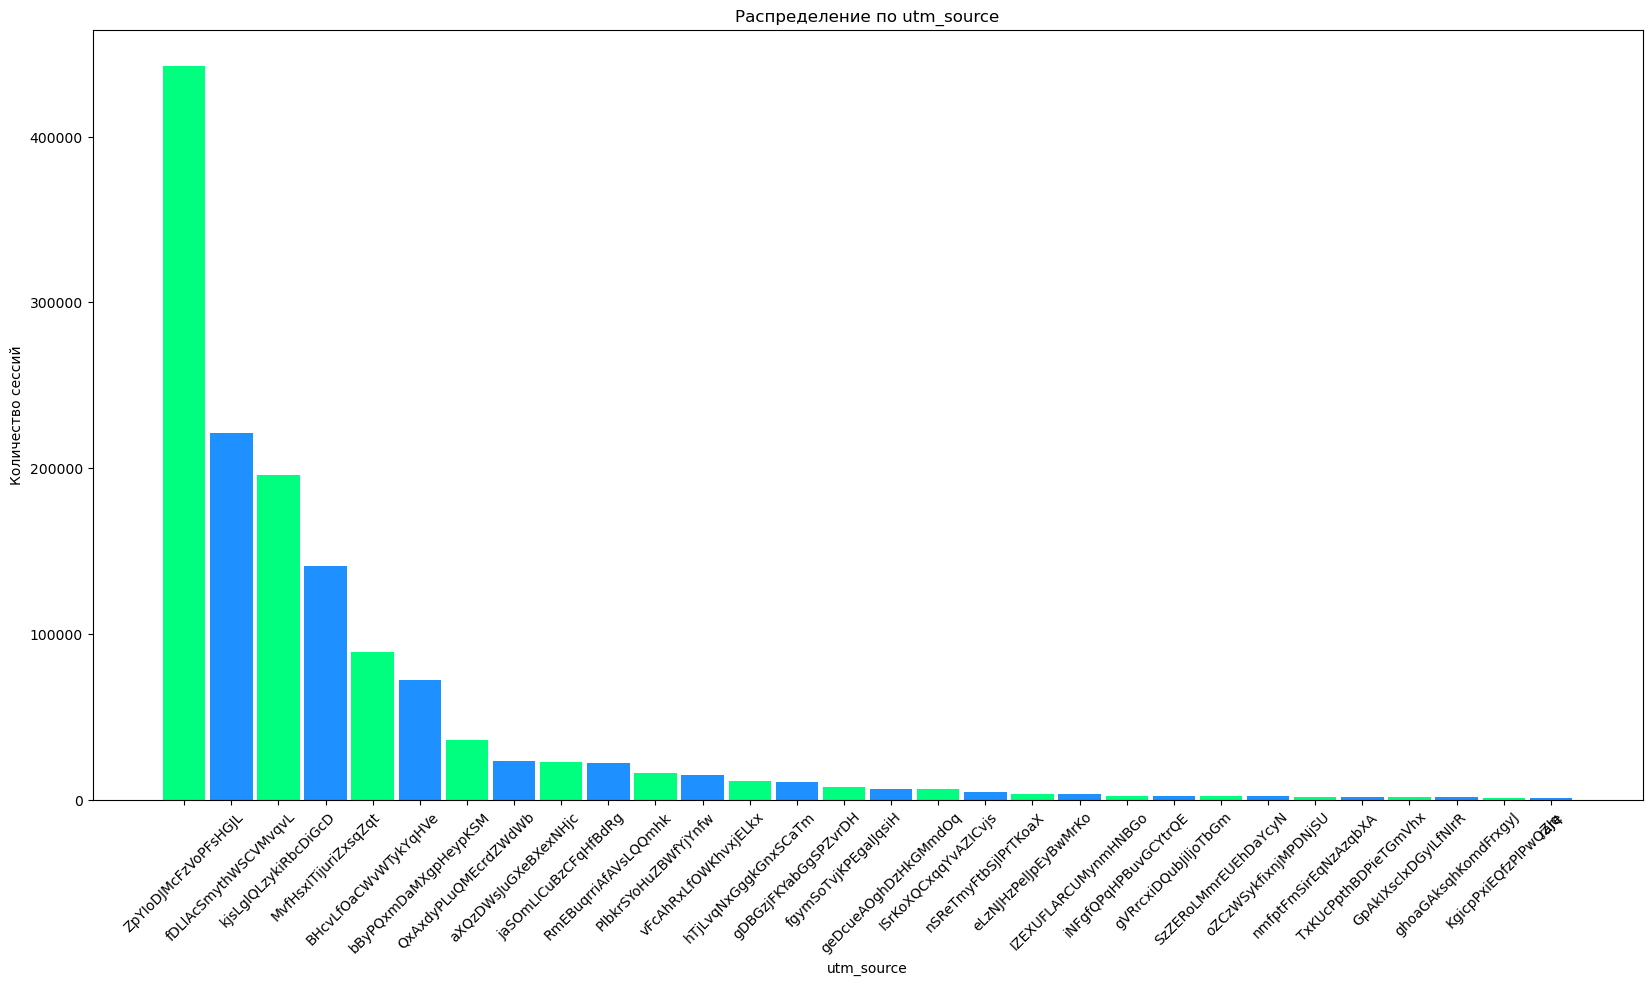

Распределение по проценту конверсии


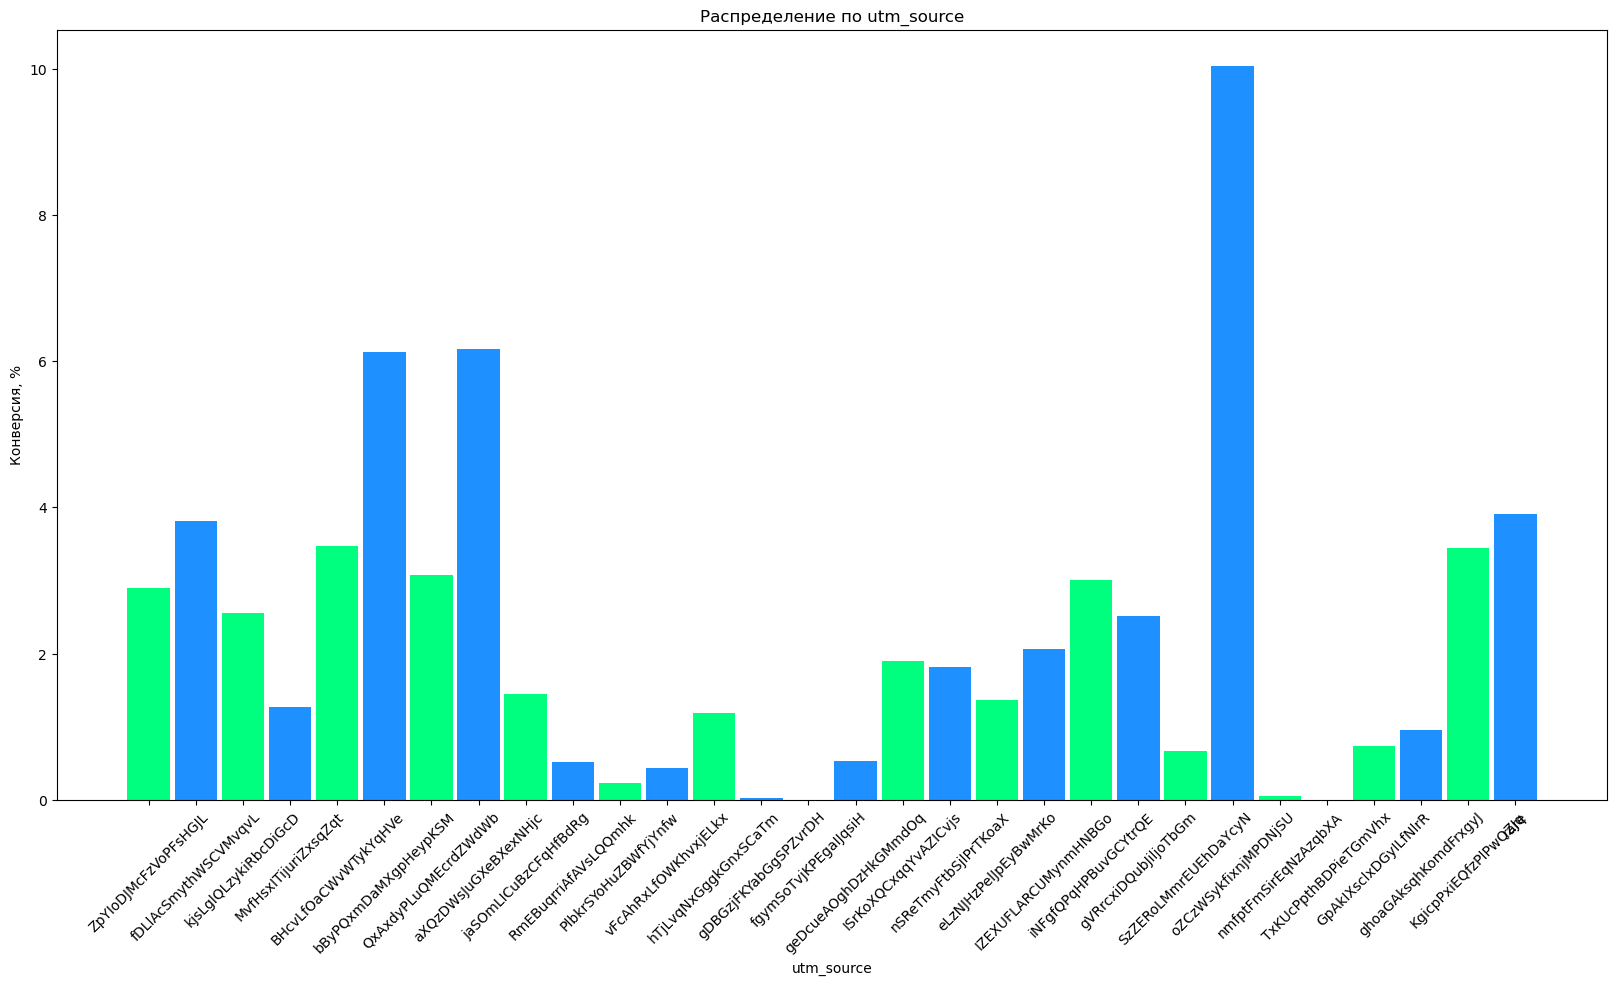

In [35]:
grafic(train, 'utm_source', 30)

На графике для наглядности показаны только 30 лучших каналов превлечения, очевидно, что самые популярные каналы обладают не самой лучшей конверсией, а некоторые из достаточно популярных вообще имеют нулевую конверсию.

#### Колонка utm_medium

Распределение по кол-ву сессий


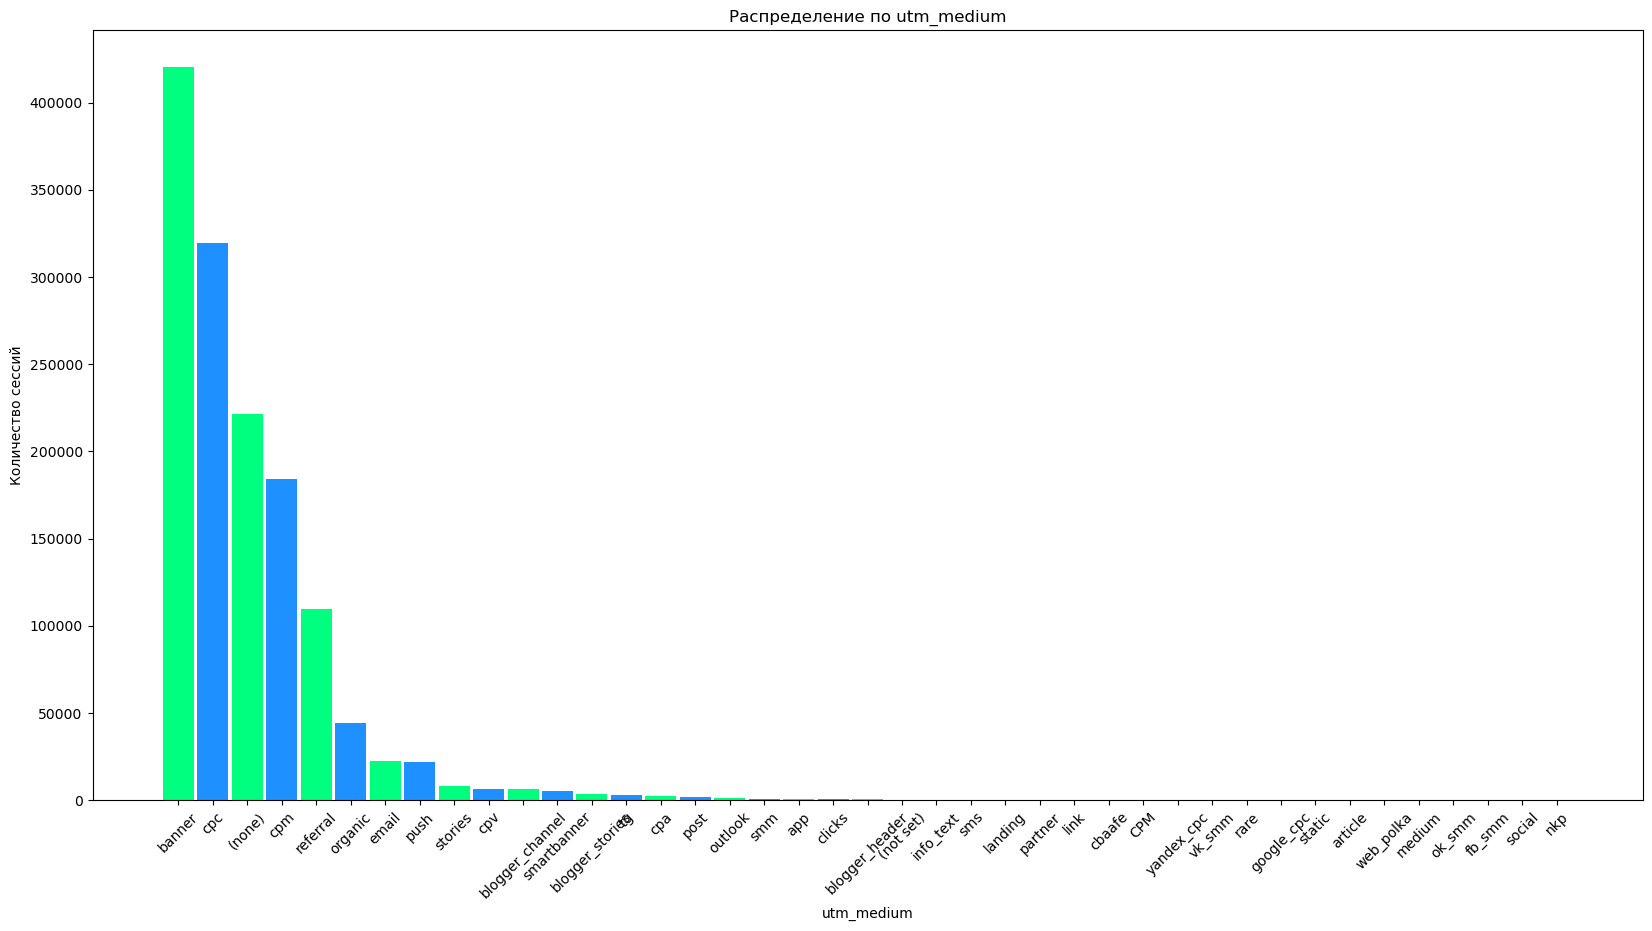

Распределение по проценту конверсии


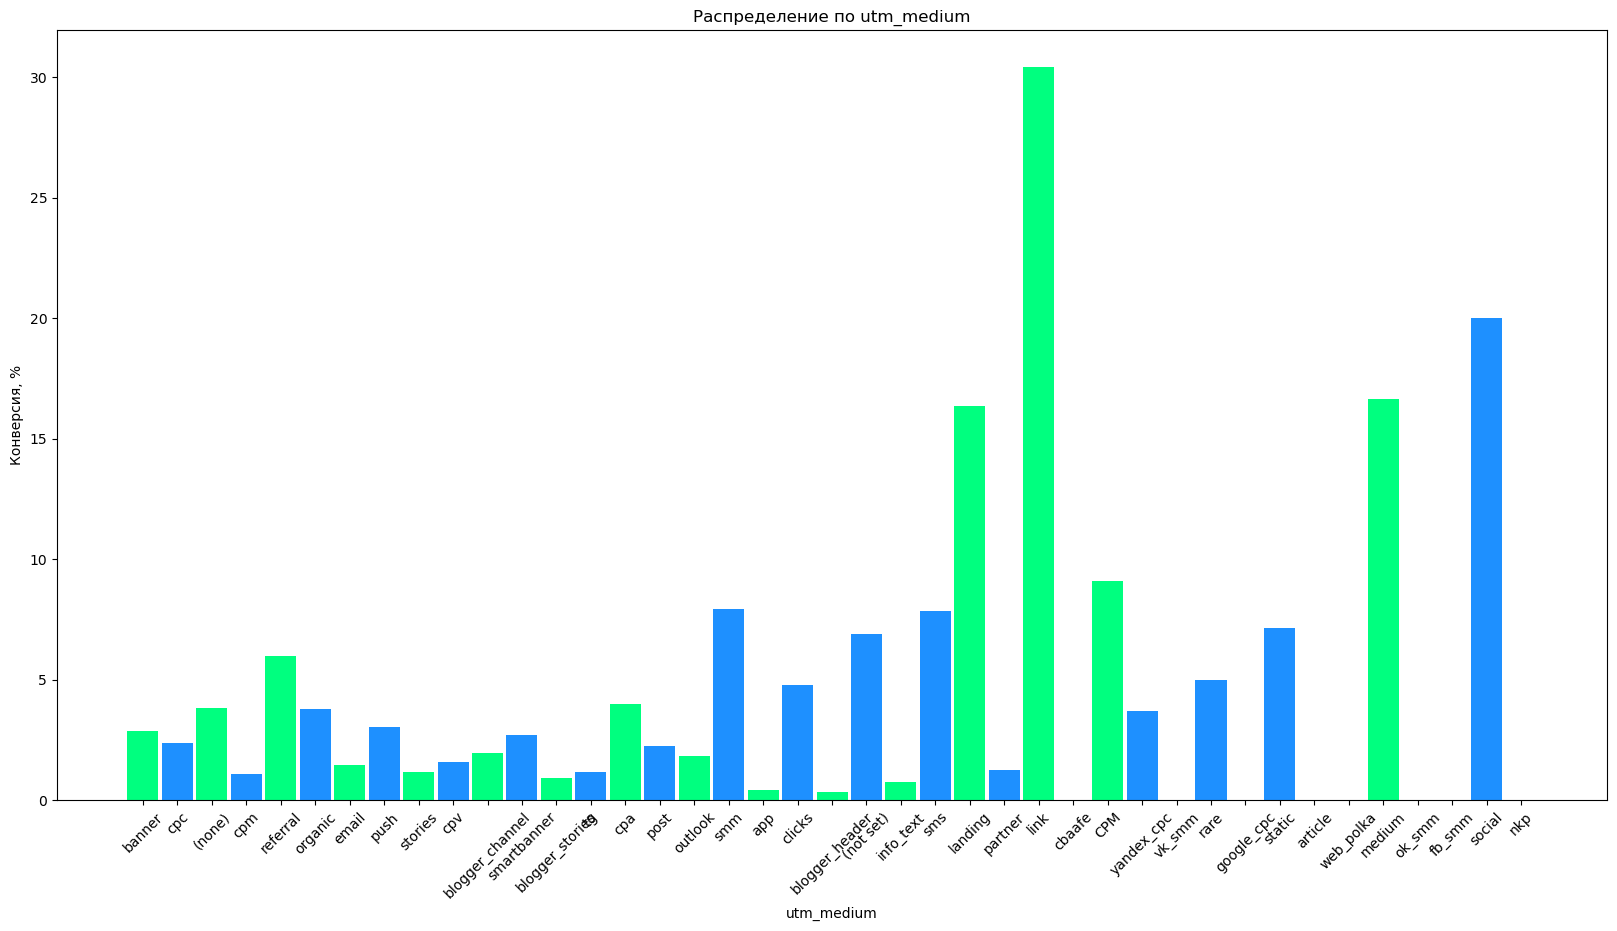

In [36]:
grafic(train, 'utm_medium', 60)

Из графика  очевидно, что самые популярные типы привлечения обладают не самой лучшей конверсией, скорее даже наоборот. Самым лучшим с точки зрения конверсии является тип qrcodevideo(100%), однако он почти самый худший с точки зрения количества сессий.

#### Колонка utm_campaign

Распределение по кол-ву сессий


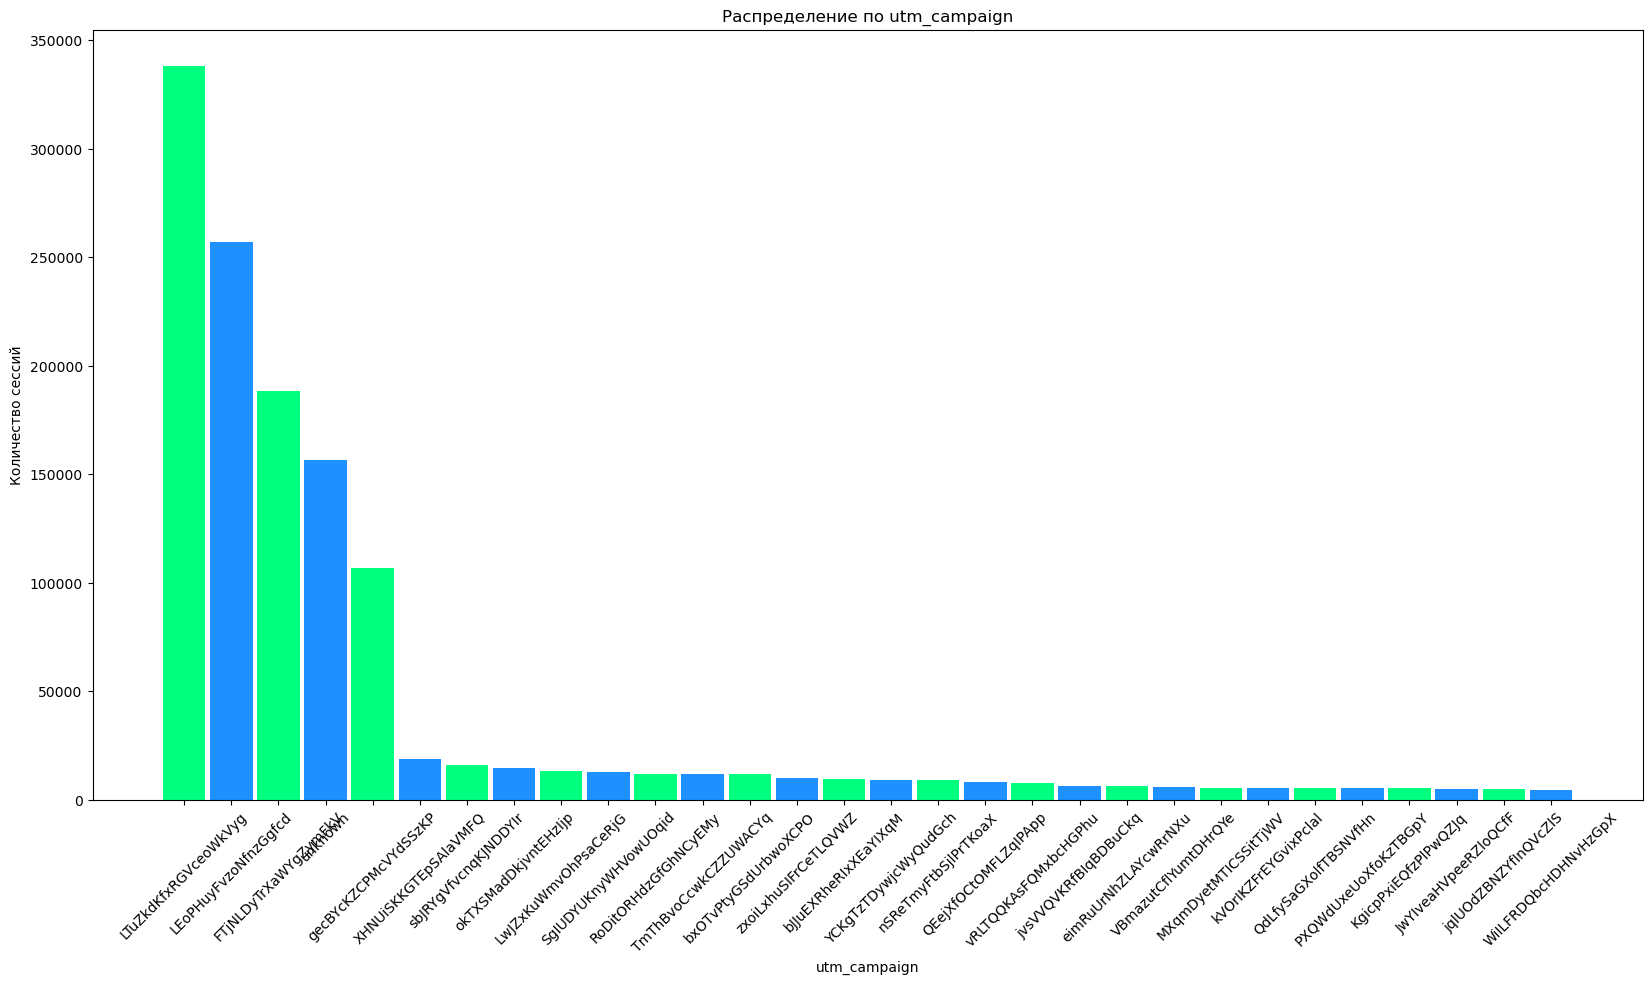

Распределение по проценту конверсии


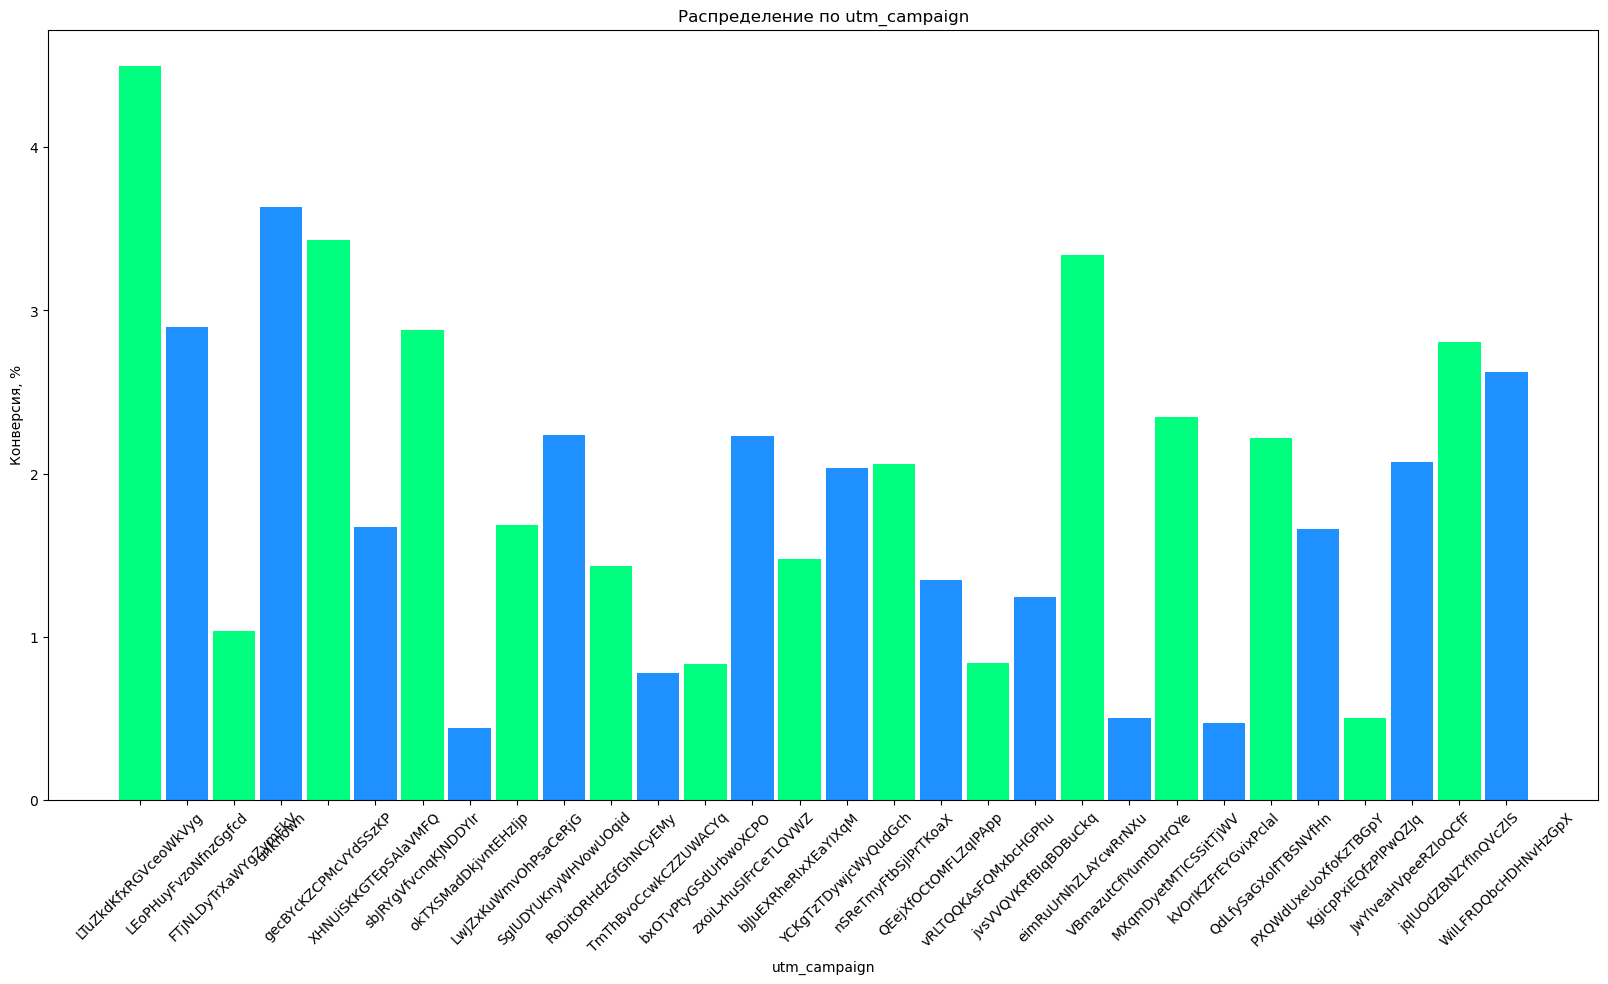

In [37]:
grafic(train, 'utm_campaign', 30)

В зависимости от рекламной компании четких зависимостей не выявлено.

#### Колонка utm_adcontent

Распределение по кол-ву сессий


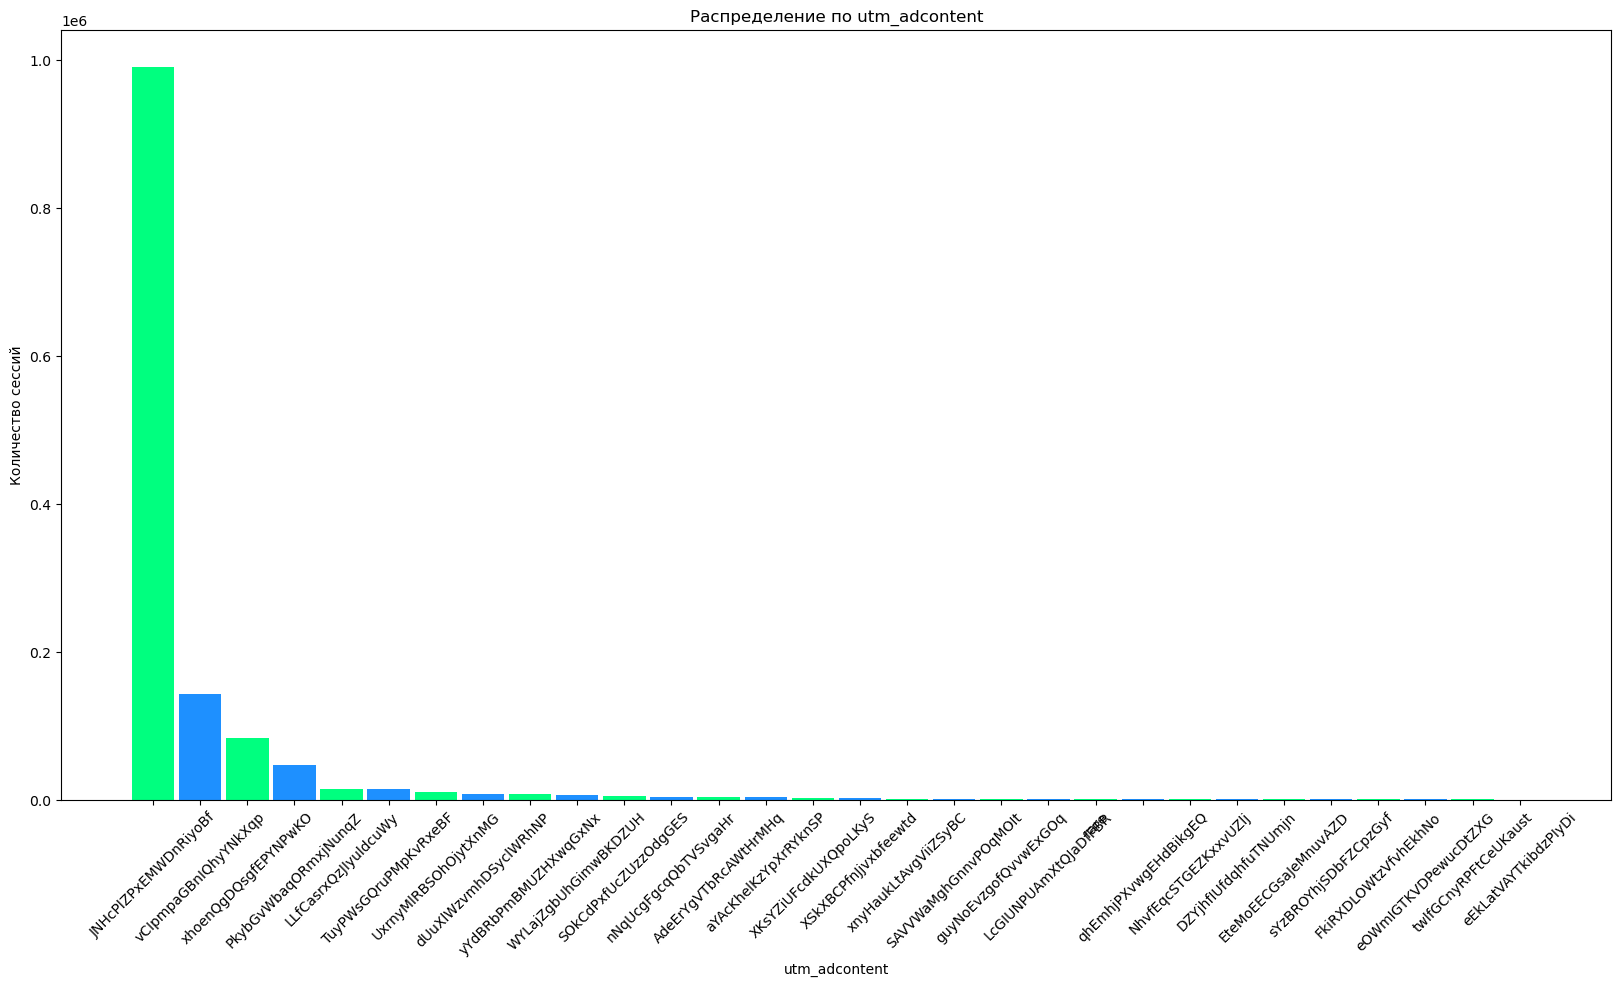

Распределение по проценту конверсии


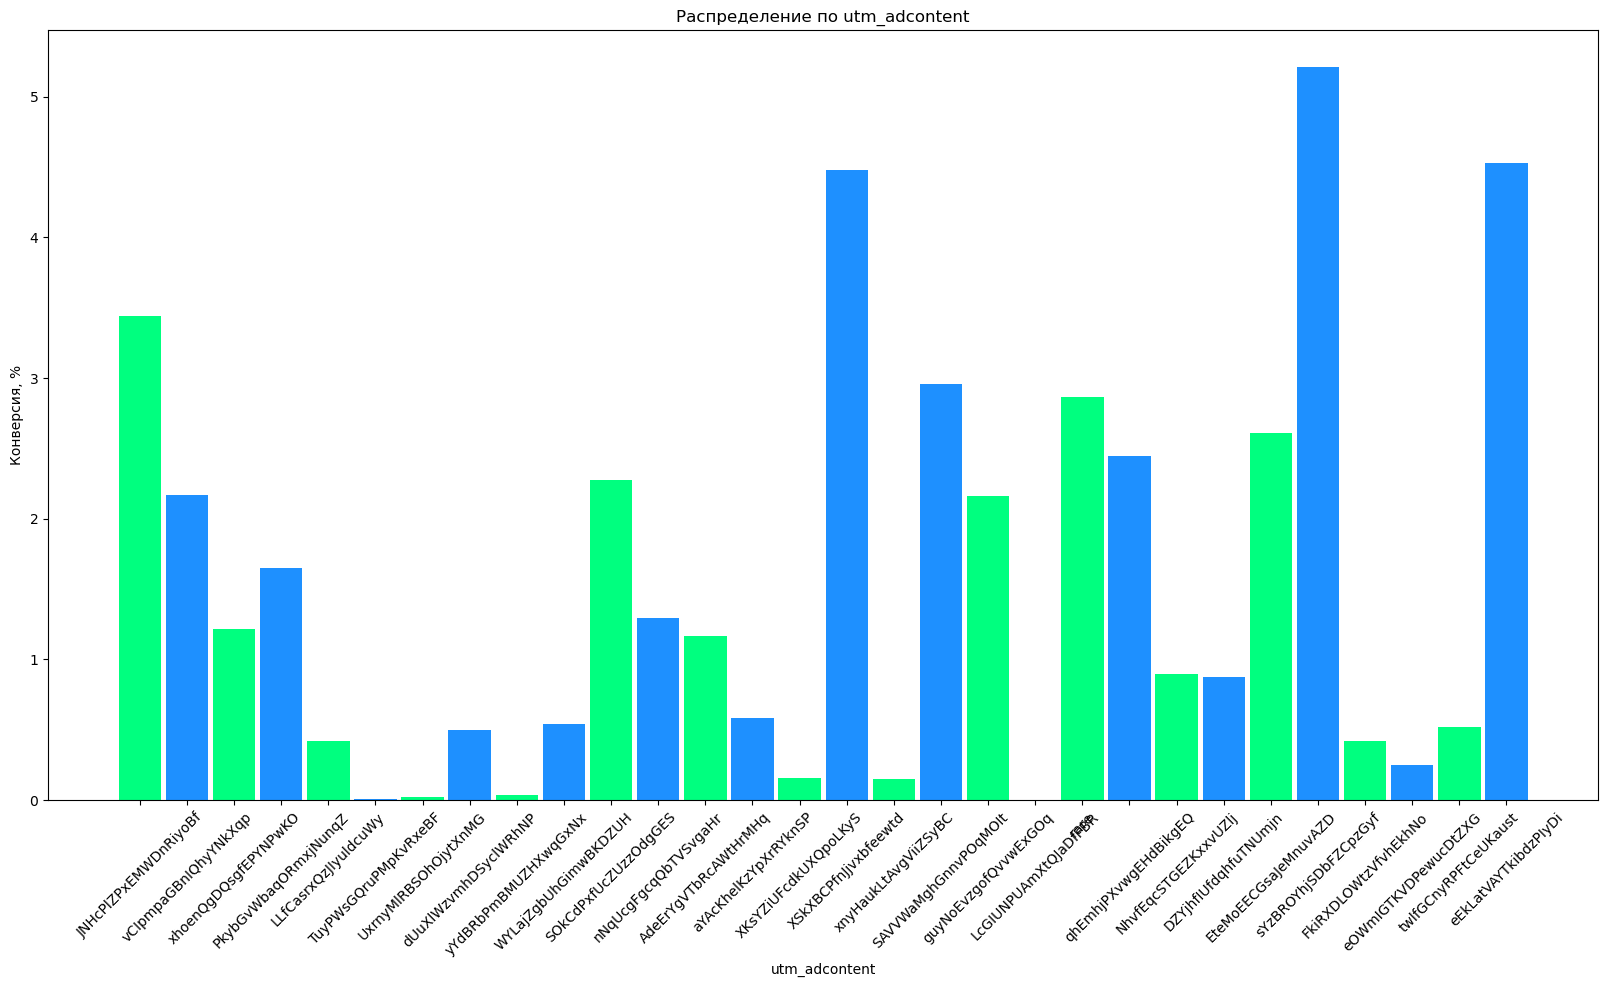

In [38]:
grafic(train, 'utm_adcontent', 30)

Описаний данной колонки в задании нет, но здесь также видно, что лучшая конверсия наблюдается не у самых популярных каналов.
В целом рекомендация: пересмореть каналы и типы привлечения.

#### Колонка device_category

Распределение по кол-ву сессий


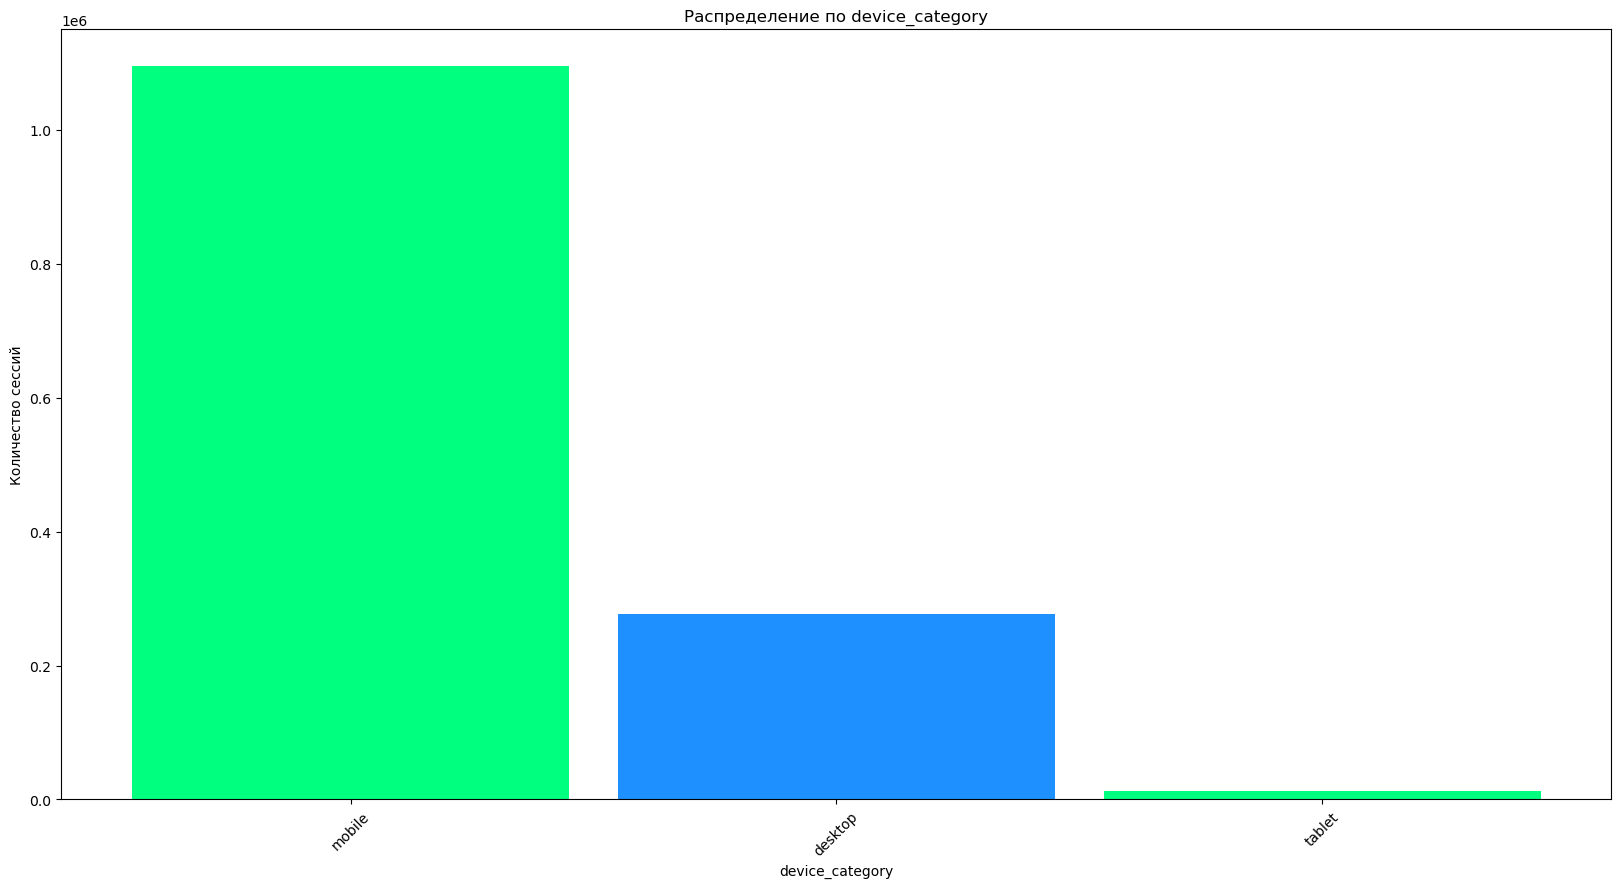

Распределение по проценту конверсии


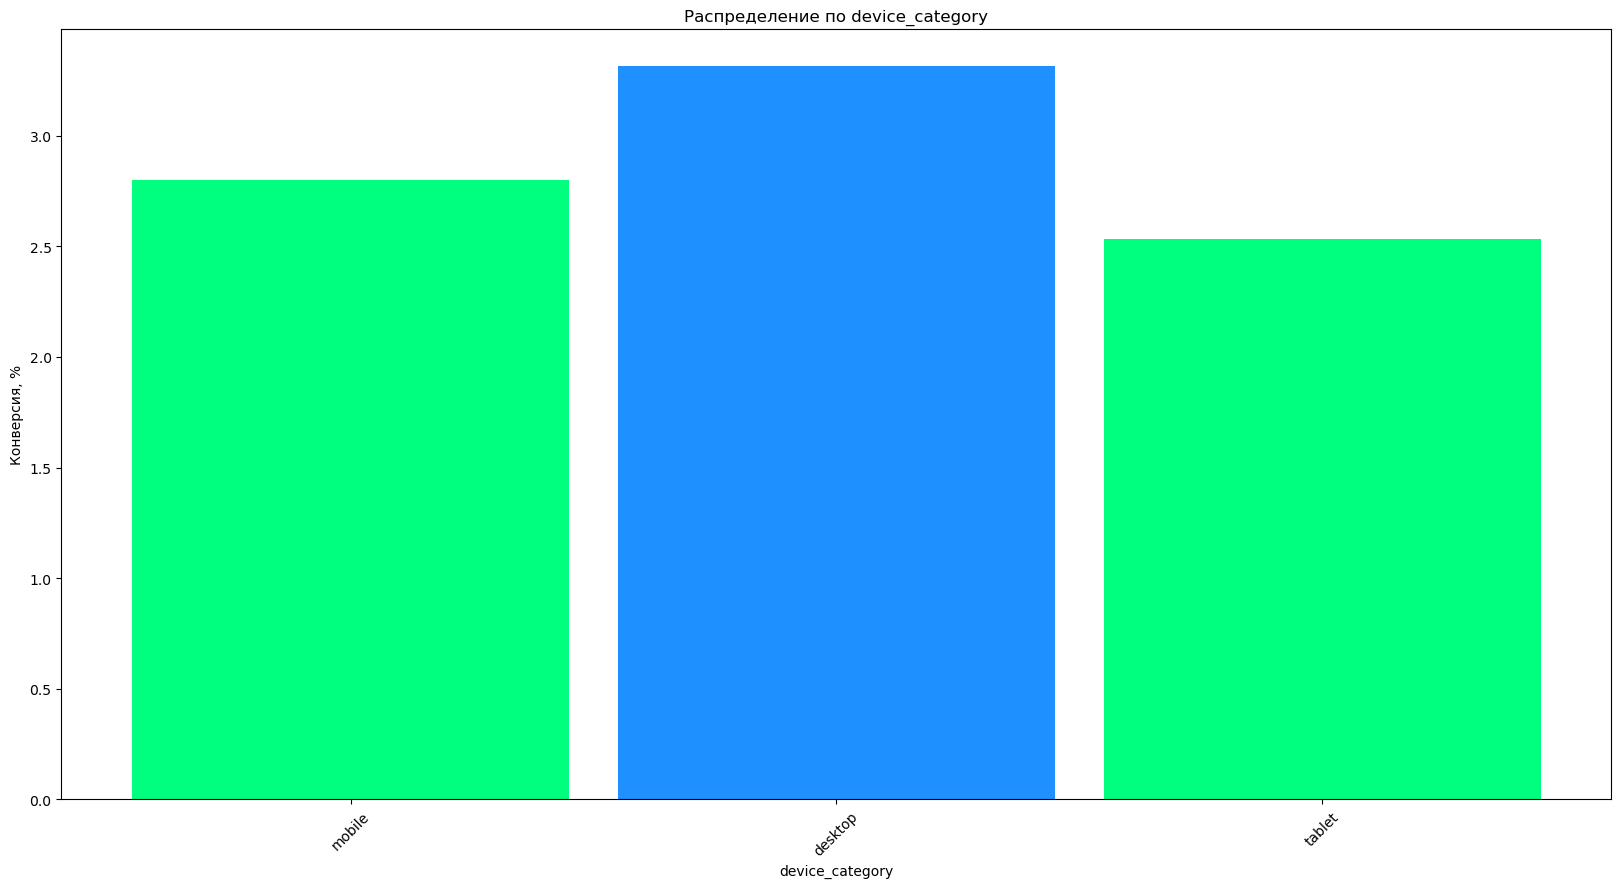

In [39]:
grafic(train, 'device_category', 3)

Самая высокая посещаемость с мобильных устройств, но при этом самая высокая конверсия у деслтопных. Рекомендации: улучшить
удобство(расположение ключевых кнопок и т.п.) мобильного приложения, возможно есть смысл отказаться от поддержки приложения 
на планшетах.

#### Колонка device_brand

Распределение по кол-ву сессий


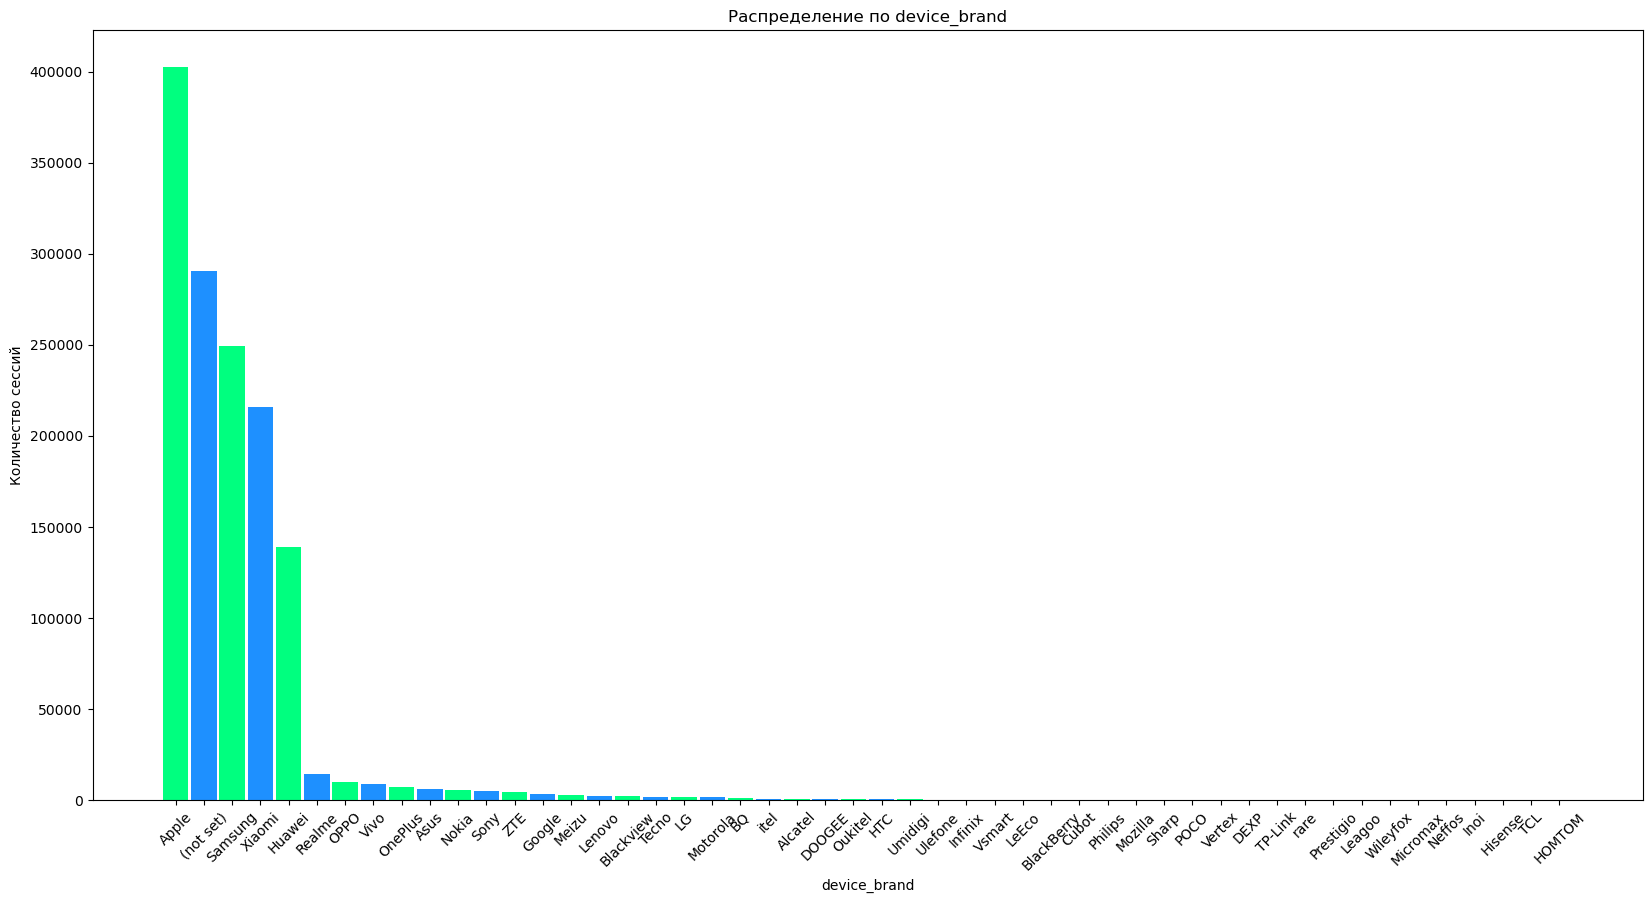

Распределение по проценту конверсии


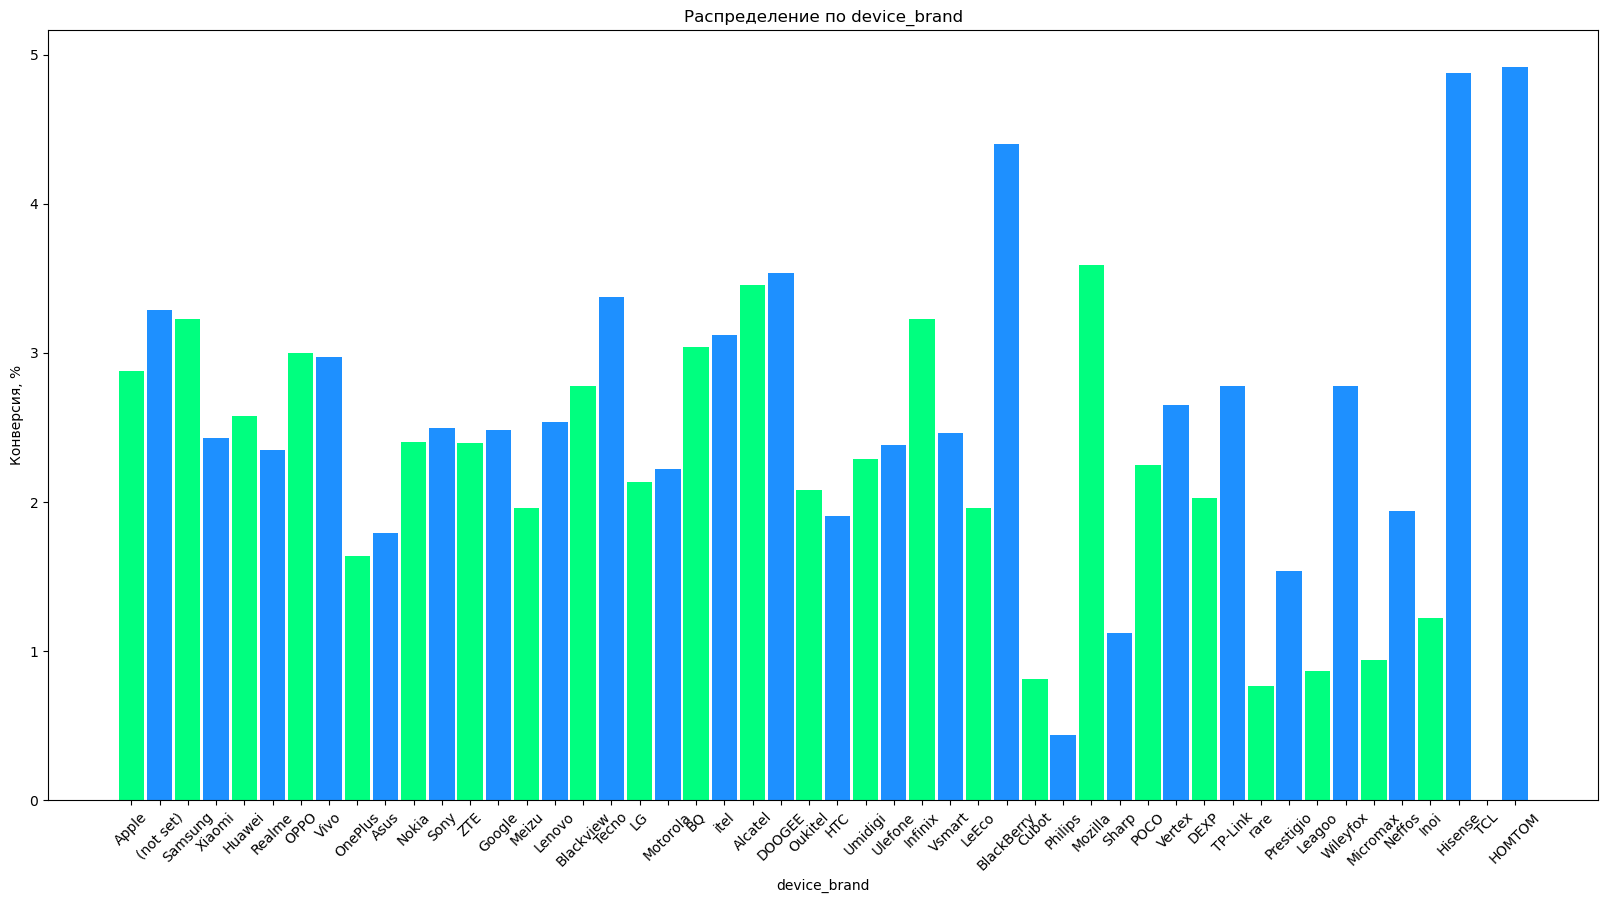

In [40]:
grafic(train, 'device_brand', 50)

Самая высокая посещаемость с устройств Apple, здесь следует учесть, что очень устройств не определено, следует разобраться почему.

#### Колонка device_browser

Распределение по кол-ву сессий


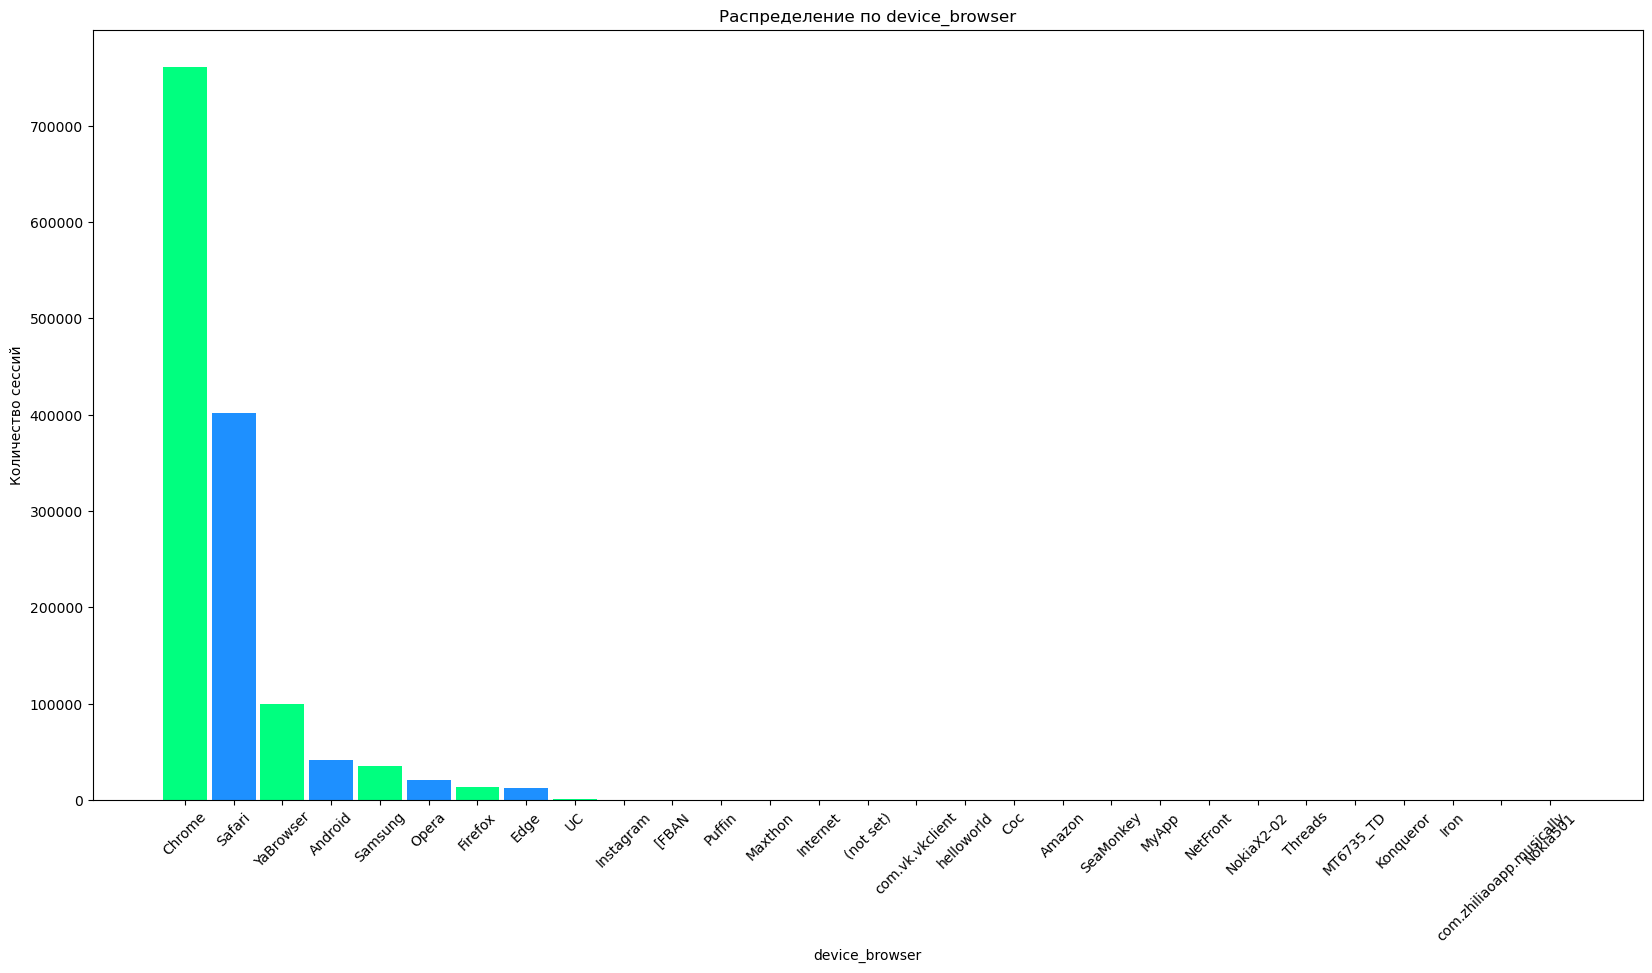

Распределение по проценту конверсии


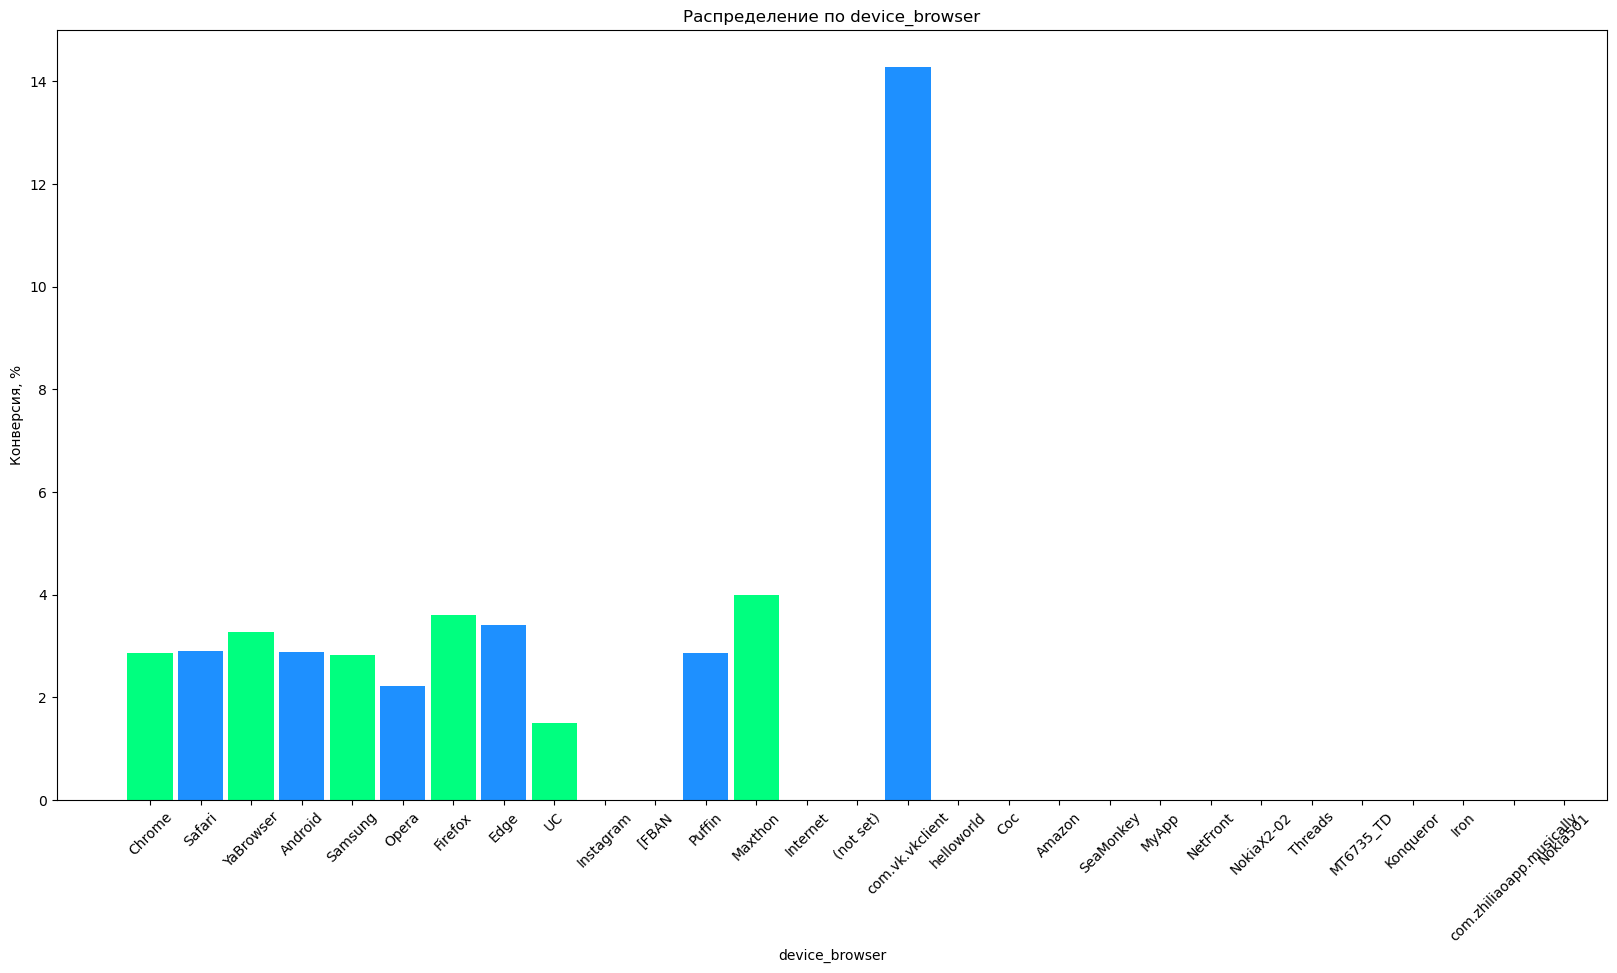

In [41]:
grafic(train, 'device_browser', 50)

Здесь необходимо обратить внимание, что самый конверсионный браузер com.vk.vkclient. Следует присмотреться к этой информации, 
возможно стоит усилить рекламу в vk.

#### Колонка geo_country

Распределение по кол-ву сессий


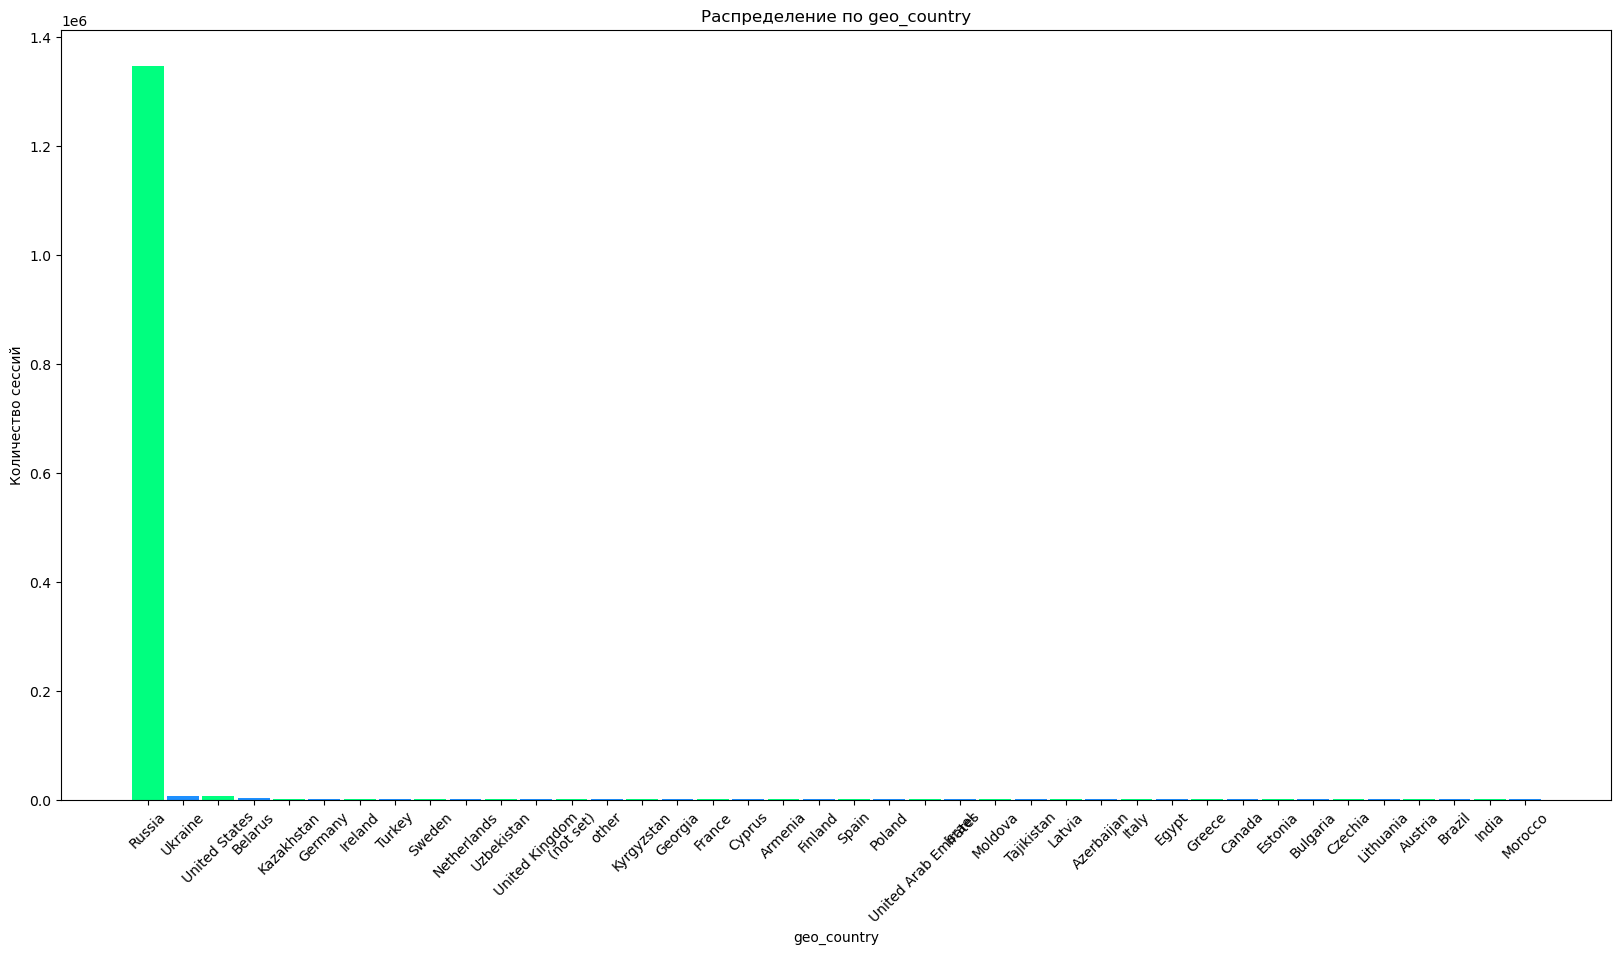

Распределение по проценту конверсии


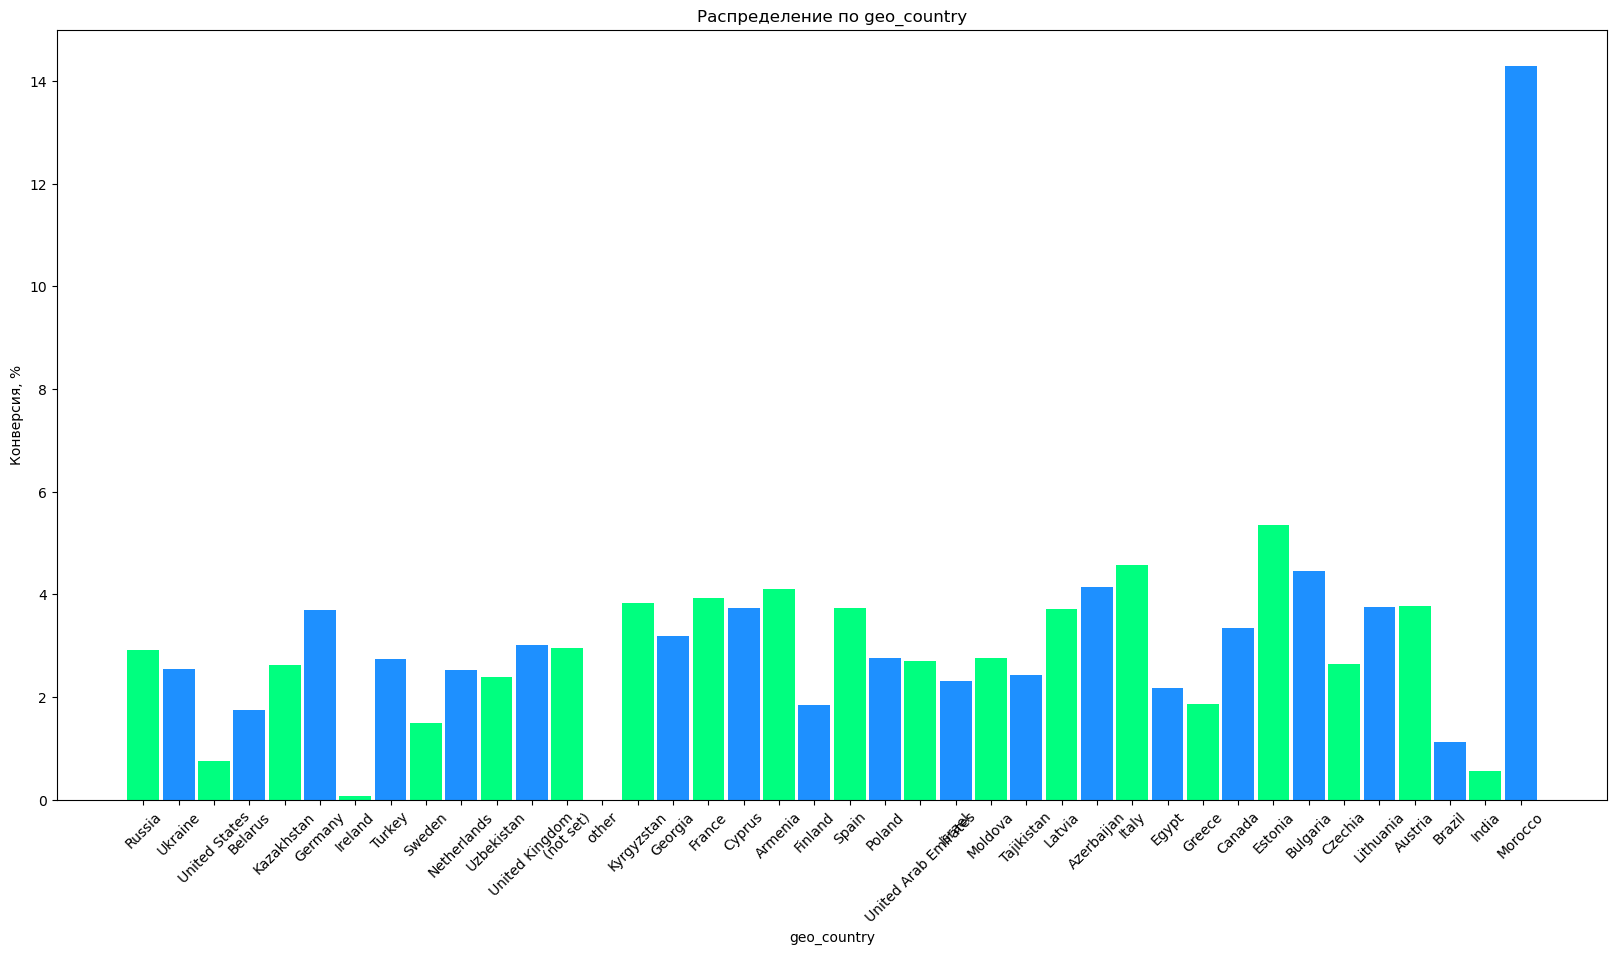

In [42]:
grafic(train, 'geo_country', 40)

Очевидно, что целевая аудитория находится в России. На что стоит обратить внимание в ближнем зарубежье(Казахстан, Германия, Турция) конверсия достаточно высока, надо наблюдать это страны-кадидаты на открытие своего представительства. Интересна также высокая конверсия в Морокко и Эстонии.

#### Колонка geo_city

Распределение по кол-ву сессий


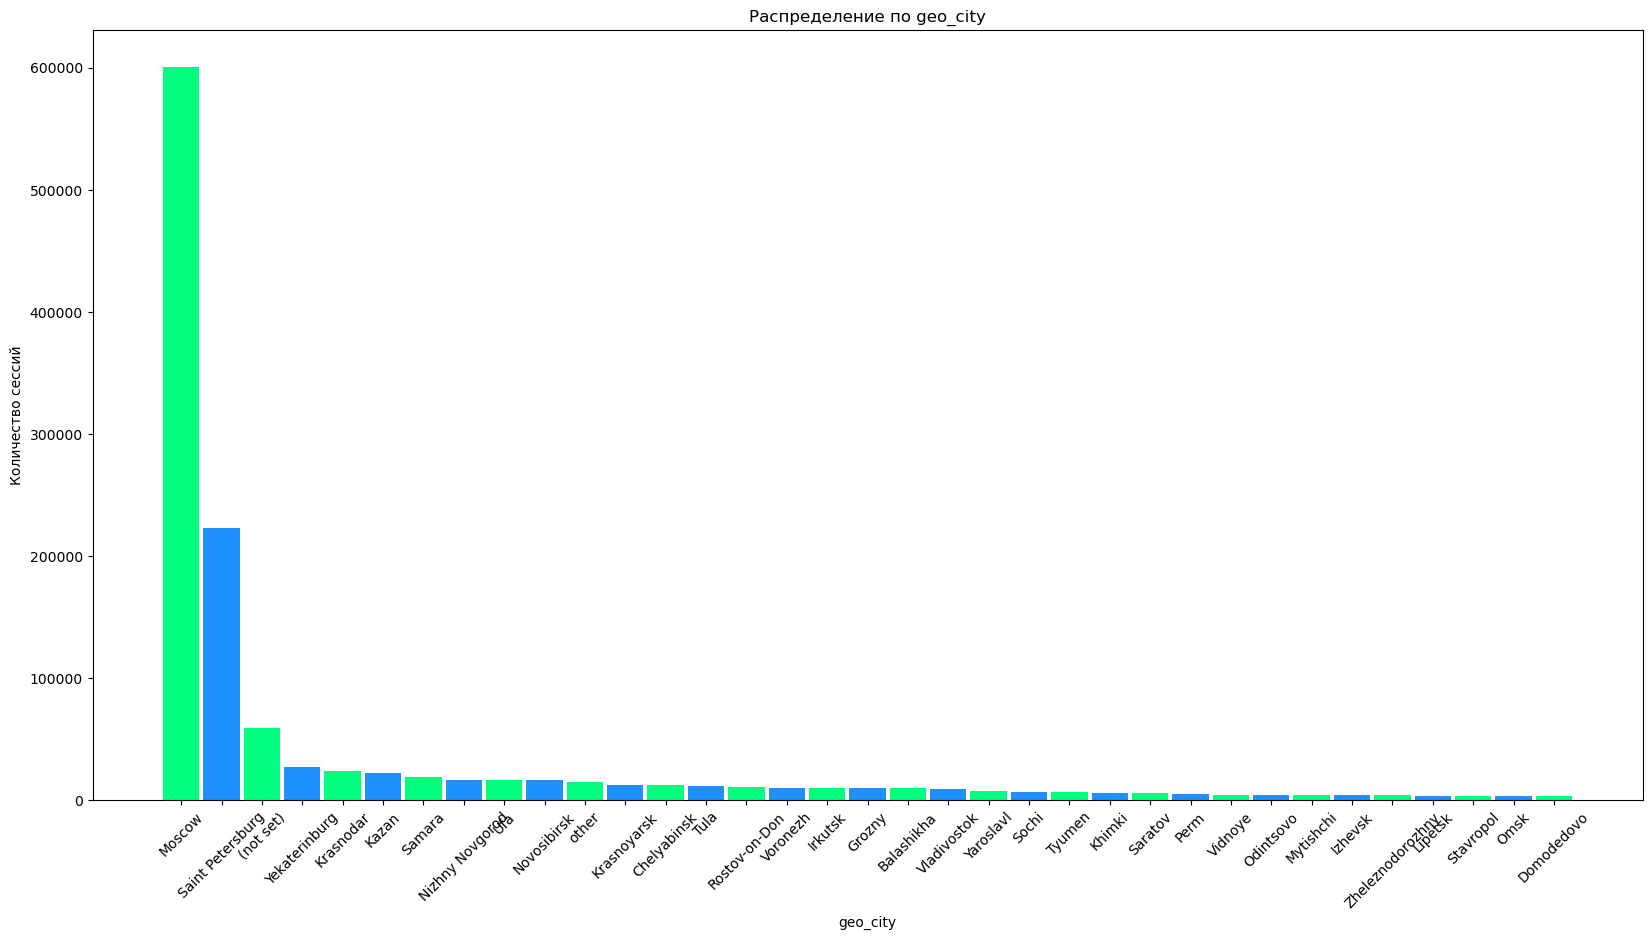

Распределение по проценту конверсии


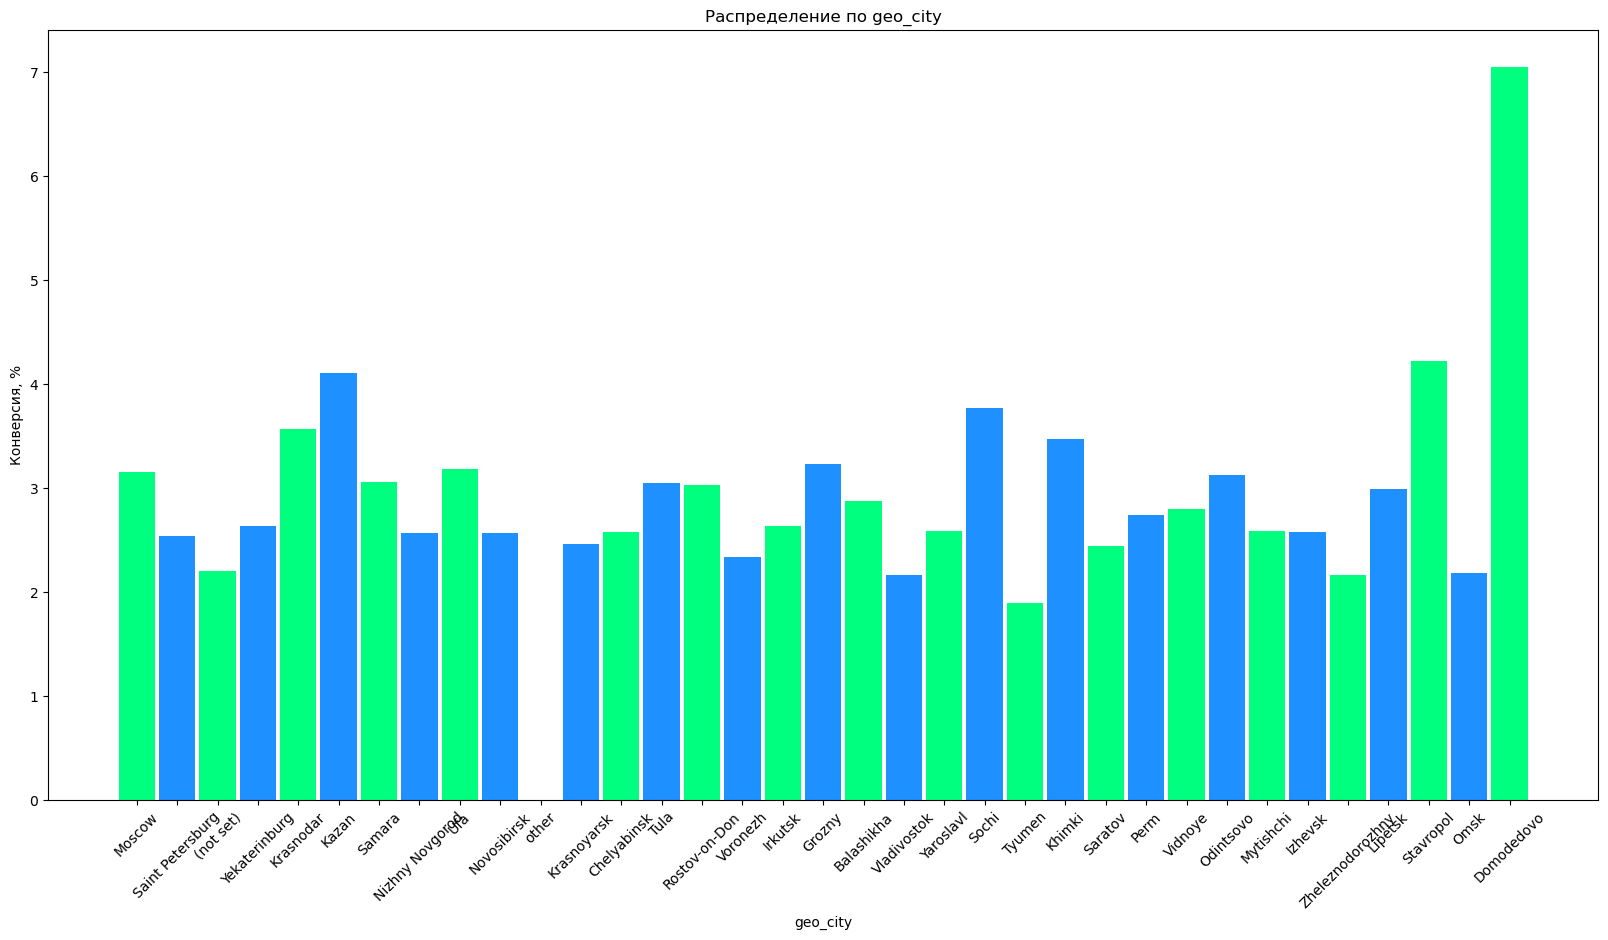

In [43]:
grafic(train, 'geo_city', 35)

В графиках явно присутствует зависимость от кол-во жителей в городах. Но все равно исходя из графиков видно, что стоит подумать
о дополнитльных офисах в Санкт-Петербурге(кол-во сессий), Карснодаре и Казани(высокая конверсия), а также об удобстве клиентов из Московской области, эти города хоть и не являются лидерами по численности, но в достаточно большом кол-ве присутствуют в топе городов и обладают относительно хорошей конверсией.

### Временные переменные

In [44]:
def grafic_time(df, column):
    
    df_sum = df.groupby([column], as_index=False)[['target']].sum()
    df_count = df.groupby([column], as_index=False)[['target']].count()
    df_count['conversion'] = df_sum.target * 100/ df_count.target
   
    df_count = df_count.sort_values(by=[column], ascending=False)
   
    print('Распределение по кол-ву сессий')
    plt.figure(figsize=(12, 6))
    plt.plot(df_count[column], df_count['target'])
    plt.xlabel(column)
    plt.ylabel('Количество сессий')
    
    plt.title(f'Распределение по {column}');
    plt.show()
    print('График по проценту конверсии')
    plt.figure(figsize=(12, 6))
    plt.plot(df_count[column], df_count['conversion'])
    plt.xlabel(column)
    plt.ylabel('Конверсия, %')
    
    plt.title(f'Распределение по {column}');
    plt.show()

#### Колонка visit_time

Распределение по кол-ву сессий


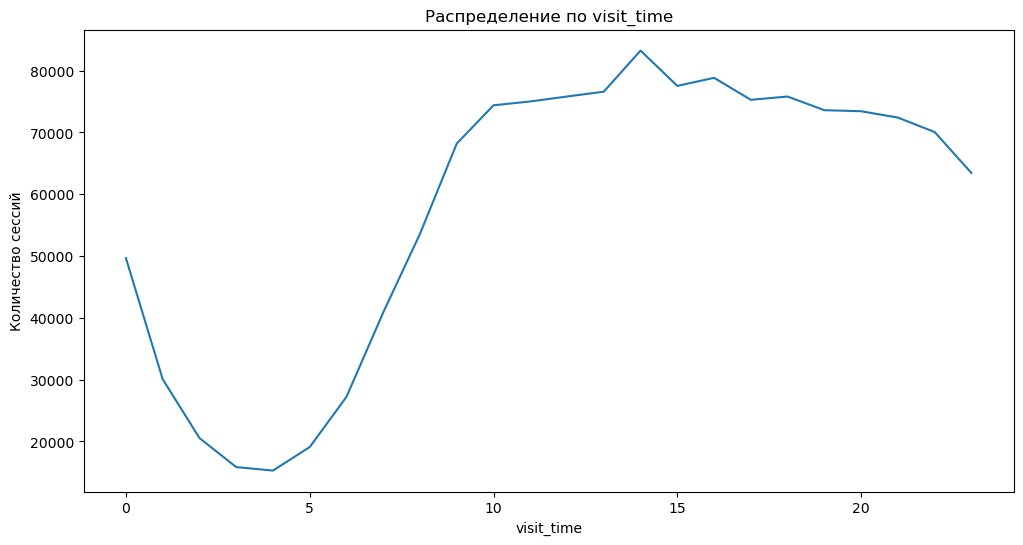

График по проценту конверсии


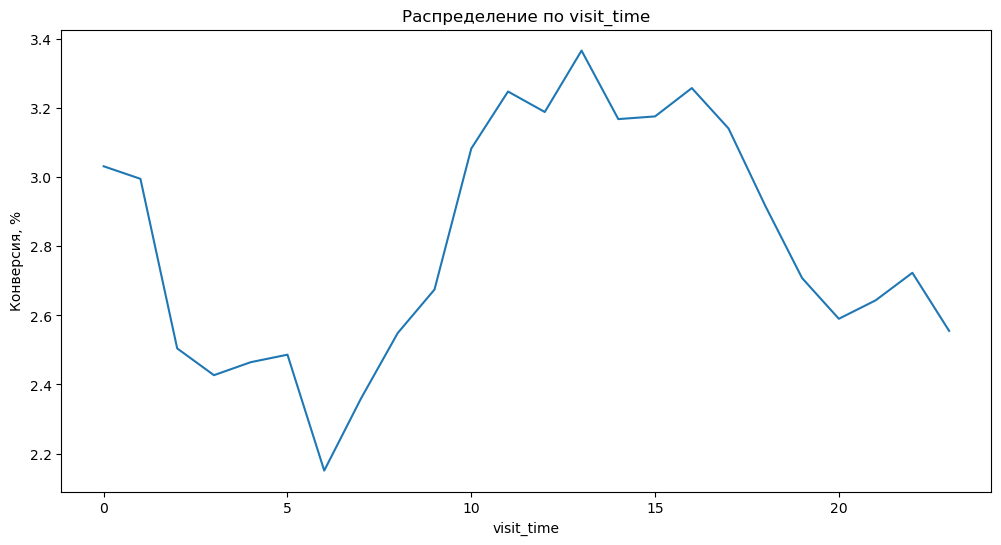

In [45]:
grafic_time(train, 'visit_time')

Из графиков видно, что в трафике присуствет явная просадка в ночное время, это время можно использовать для загрузки обновлений.

#### Колонка day

Распределение по кол-ву сессий


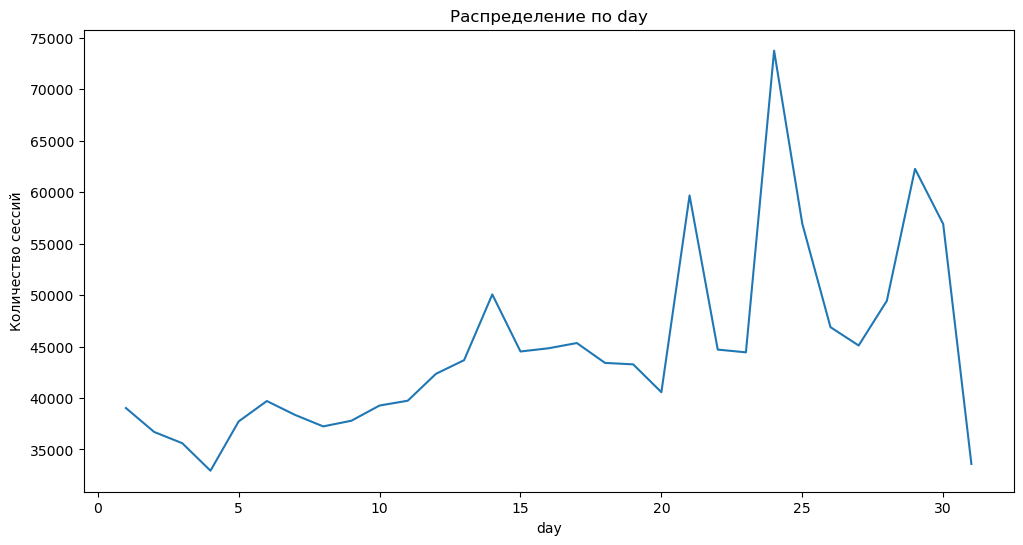

График по проценту конверсии


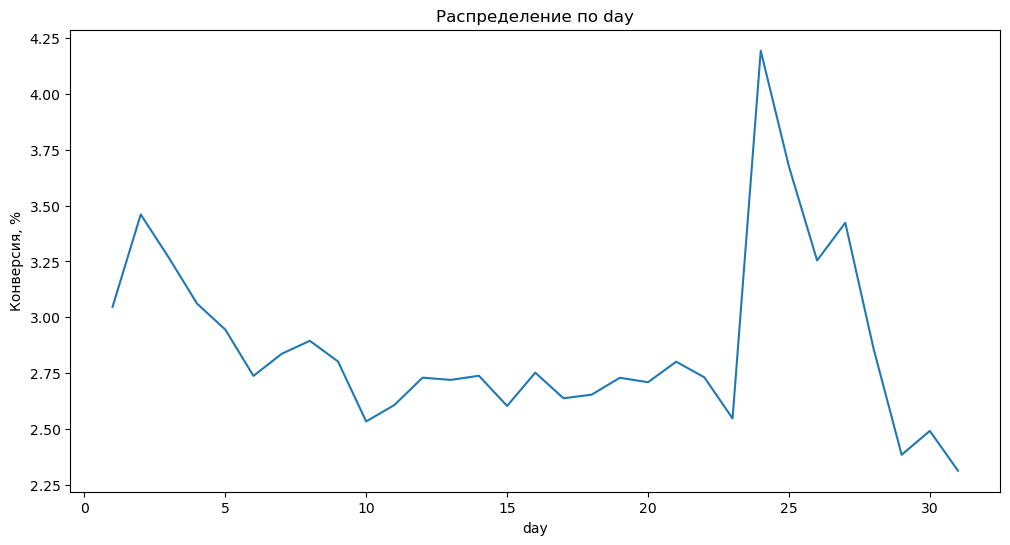

In [46]:
grafic_time(train, 'day')

График по дням месяца не дает четкой картины, кроме того, что в 20-х числах месяца резкий скачок и количества сессий и конверсии, может быть это связано с проведением рекламных компаний.

#### Колонка day_of_week

Распределение по кол-ву сессий


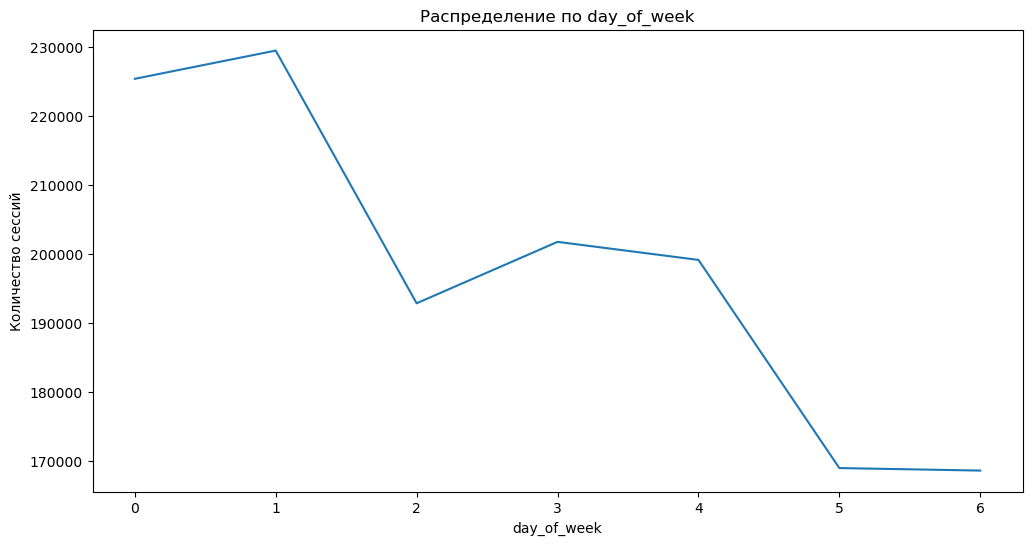

График по проценту конверсии


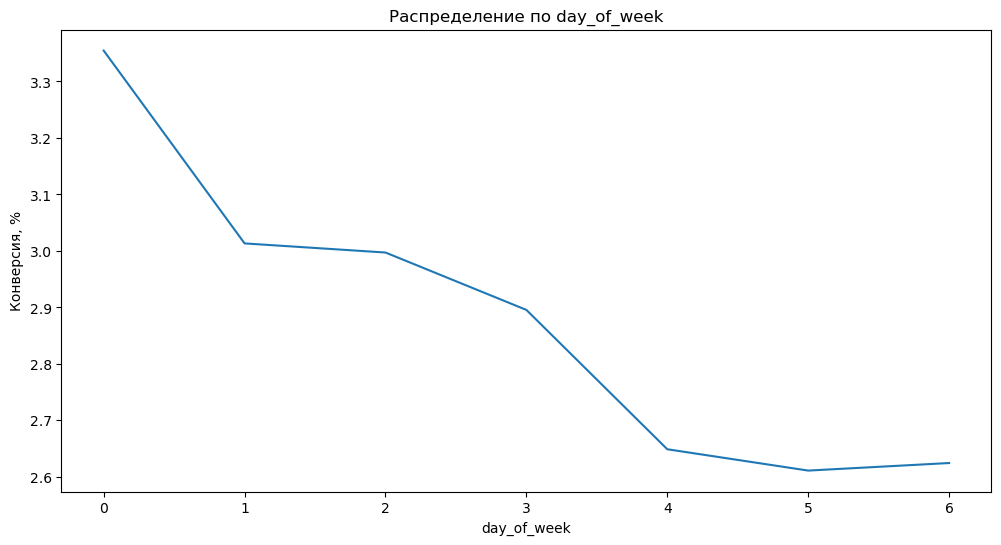

In [47]:
grafic_time(train, 'day_of_week')

Здесь мы имеем четкую обратно-пропорциональную зависимость от номера дня недели, т.е. с понедельника по воскресенье количество сессий и конверсия падают.

#### Колонка month

Распределение по кол-ву сессий


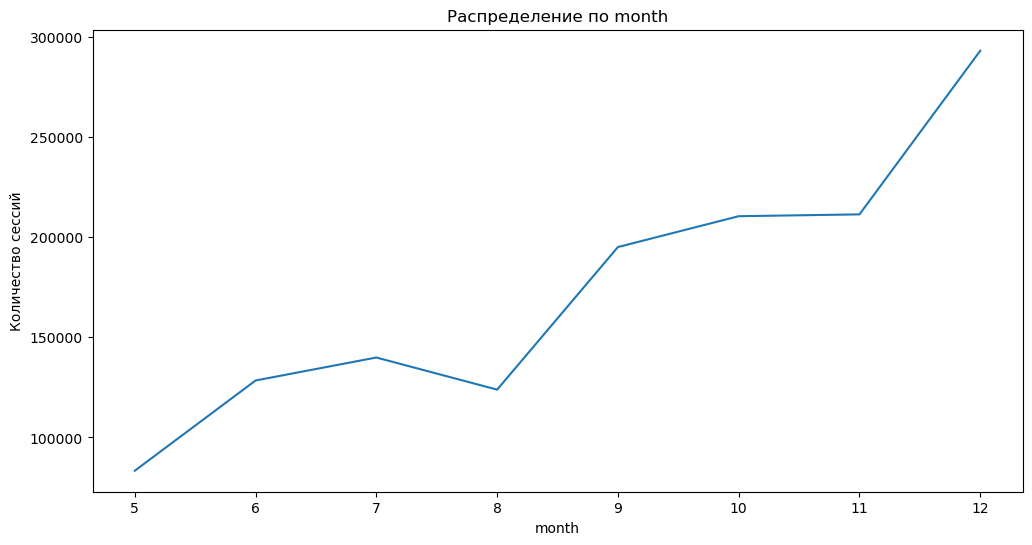

График по проценту конверсии


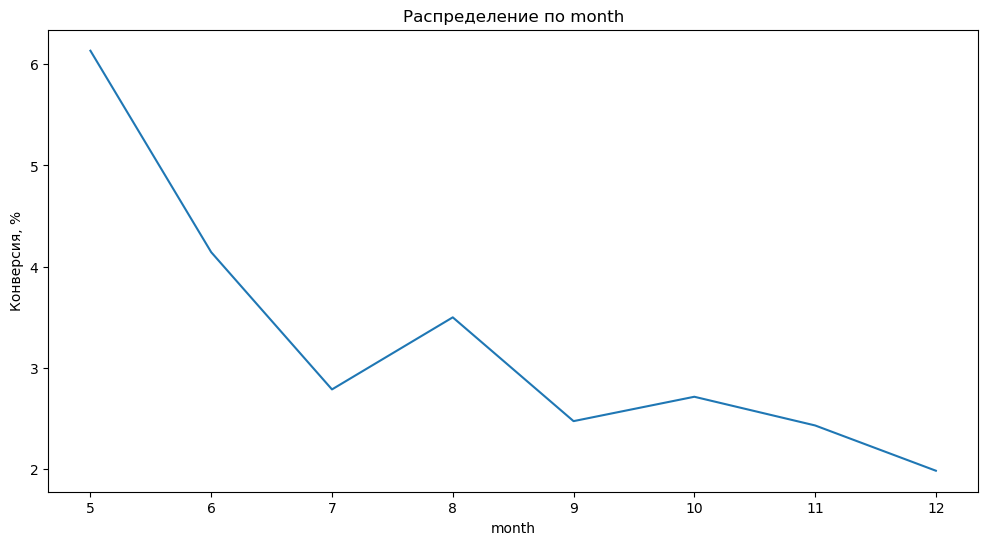

In [48]:
grafic_time(train, 'month')

В этом случае мы явную дивергенцию двух графиков. В течении года кол-во сессий росло, т.е. интерес к компании увеличивался.
Но при это конверсия падала, это также может говорить о не рациональной рекламной компании и привлечении не целевых клиентов.

### Прочие колонки

#### Колонка visit_number

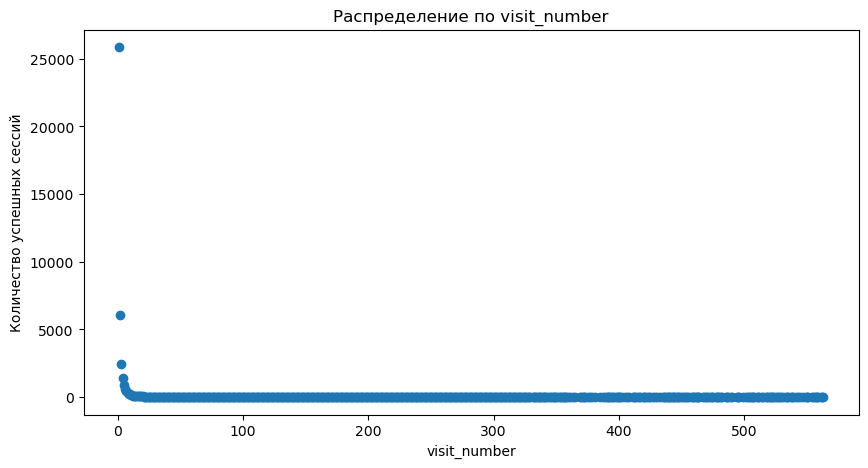

In [49]:
train_visit_number = train.groupby(['visit_number'], as_index=False)[['target']].sum()
train_visit_number = train_visit_number.rename(columns={'target': 'sum'})
plt.figure(figsize=(10, 5))
plt.scatter(train_visit_number['visit_number'], train_visit_number['sum'])
plt.xlabel('visit_number')
plt.ylabel('Количество успешных сессий')

plt.title('Распределение по visit_number');

График функции похож 1/x**2, попробуем использовать при образовании новых фичей.

#### Колонка device_screen_resolution

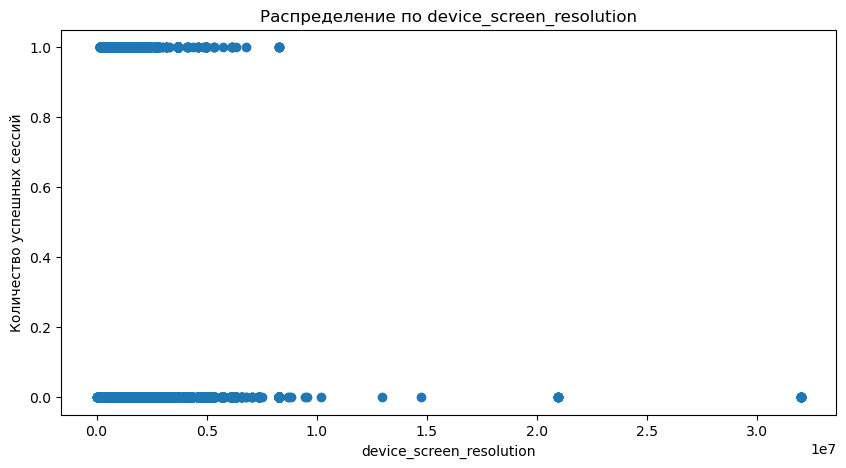

In [50]:

plt.figure(figsize=(10, 5))
plt.scatter(train['device_screen_resolution'], train['target'])
plt.xlabel('device_screen_resolution')
plt.ylabel('Количество успешных сессий')

plt.title('Распределение по device_screen_resolution');

Слишком большие размеры экрана не имеют не одной положительной сессии, используем это на этапе фича инжиниринга.

Построим матрицу корреляций между признаками

<AxesSubplot:>

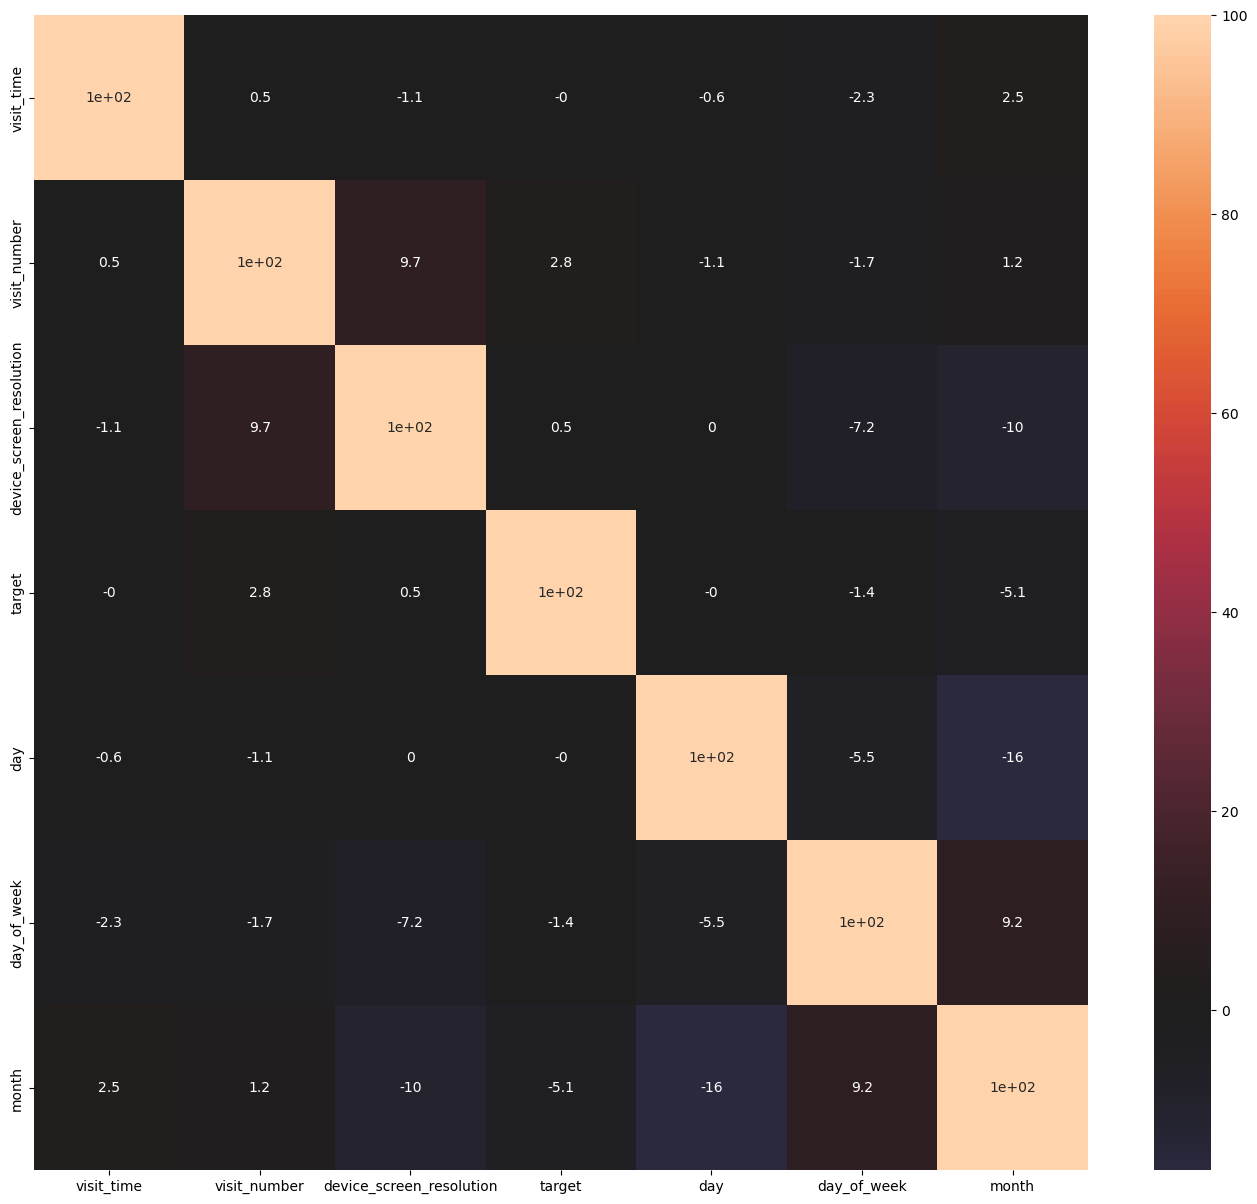

In [51]:
corr = train.drop(columns=['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'device_category', 'device_brand', 'device_browser', 'geo_country', 'geo_city'])
corr = corr.corr()
corr = corr*100
corr = corr.round(decimals = 1)
plt.figure(figsize=(17,15))
sns.heatmap(corr, center=0, annot=True)

Из диаграммы выше видно, что сильных корреляций нет. 

# 3. Feature engineering

## 3.1. Создание новой фичи на основании visit_number

На основании визуализации колонки visit_number преобразуем данную колонку

In [52]:
train.visit_number = 1 / train.visit_number**2

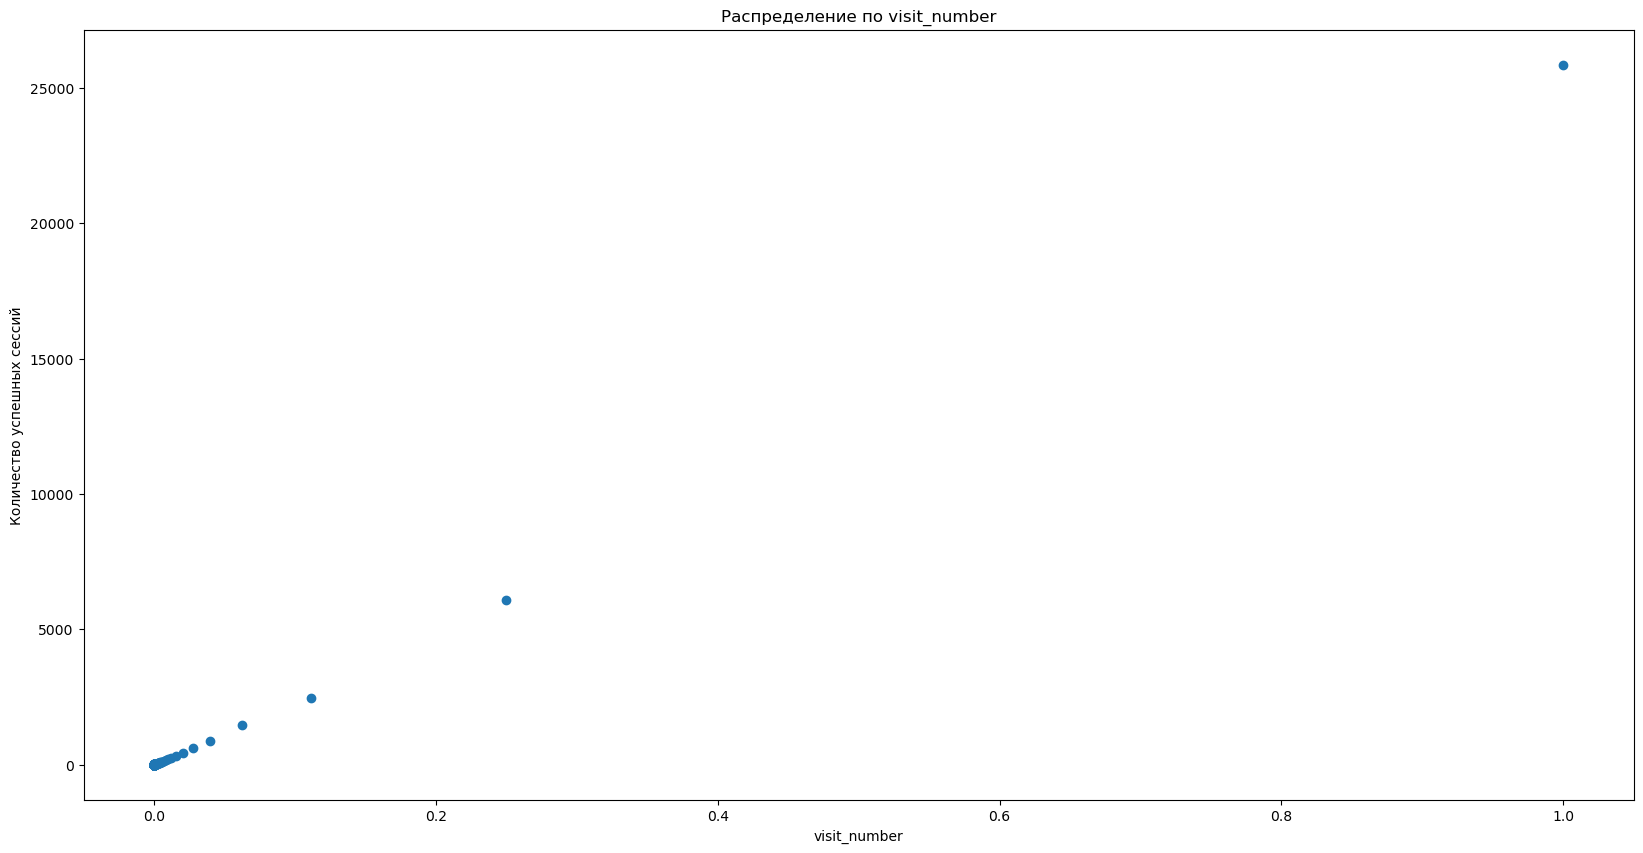

In [53]:
train_visit_number = train.groupby(['visit_number'], as_index=False)[['target']].sum()
train_visit_number = train_visit_number.rename(columns={'target': 'sum'})
plt.figure(figsize=(20, 10))
plt.scatter(train_visit_number['visit_number'], train_visit_number['sum'])
plt.xlabel('visit_number')
plt.ylabel('Количество успешных сессий')

plt.title('Распределение по visit_number');

## 3.2. Ограничение колонки device_screen_resolution

In [54]:
train.device_screen_resolution = train.device_screen_resolution.apply(lambda x: x if (x < 9 * 10**6) else 9 * 10**6)

## 3.3. Стандартизация данных

In [55]:
counts = train.drop(columns=['target']).describe().columns
data1 = train[counts]
std_scaler = StandardScaler()
std_scaler.fit(data1)
std_scaled = std_scaler.fit_transform(data1)
counts_new = [f'{el}_std' for el in counts]
train[counts_new] = std_scaled
train.drop(columns=counts, inplace=True)
train.head()

,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_browser,geo_country,geo_city,target,visit_time_std,visit_number_std,device_screen_resolution_std,day_std,day_of_week_std,month_std
696475,ZpYIoDJMcFzVoPFsHGJL,banner,SgIUDYUKnyWHVowUOqid,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,Safari,Russia,Moscow,0,-0.426173,0.570199,-0.342907,0.671939,1.110080,0.325346
1732601,QxAxdyPLuQMEcrdZWdWb,cpc,zmnpxOKDENholtspXiGy,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,Safari,Russia,Moscow,0,-0.589254,0.570199,-0.342907,1.127070,1.110080,0.778167
136315,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),Edge,Russia,Saint Petersburg,0,-0.100011,0.570199,2.446721,1.013287,-0.399717,-1.938754
1418650,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,Chrome,Russia,Perm,0,0.063070,0.570199,-0.504167,-0.921020,0.103549,1.230987
1664031,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Huawei,Chrome,Russia,Moscow,0,-0.752336,0.570199,-0.472996,1.582201,-1.406249,-1.938754


## 3.4. Преобразование категориальных переменных 

In [56]:

data2 = train[category]
ohe = OneHotEncoder(sparse=False, drop='first', dtype='int8')
ohe.fit(data2)
ohe_category = ohe.fit_transform(data2)
train[ohe.get_feature_names_out()] = ohe_category
train.drop(columns=category, inplace=True)
train

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\517550947.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

,target,visit_time_std,visit_number_std,device_screen_resolution_std,day_std,day_of_week_std,month_std,utm_source_BKeImrJuRDZcHiSSTdzm,utm_source_CFeqZLBNQdYHxJrTOHjY,utm_source_CgsxHpdTmXHvrHqEKRxp,...,geo_city_Zarechnyy,geo_city_Zheleznodorozhny,geo_city_Zheleznogorsk,geo_city_Zhukovskiy,geo_city_Zlatoust,geo_city_Zurich,geo_city_Zvenigorod,geo_city_other,geo_city_Тимофеевка,geo_city_Хомутово
696475,0,-0.426173,0.570199,-0.342907,0.671939,1.110080,0.325346,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1732601,0,-0.589254,0.570199,-0.342907,1.127070,1.110080,0.778167,0,0,0,...,0,0,0,0,0,0,0,0,0,0
136315,0,-0.100011,0.570199,2.446721,1.013287,-0.399717,-1.938754,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1418650,0,0.063070,0.570199,-0.504167,-0.921020,0.103549,1.230987,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1664031,0,-0.752336,0.570199,-0.472996,1.582201,-1.406249,-1.938754,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395954,0,0.389232,0.570199,-0.615922,0.785722,-1.406249,-1.938754,0,0,0,...,0,0,0,0,0,0,0,0,0,0
269358,0,0.389232,0.570199,-0.517264,0.444373,0.103549,0.325346,0,0,0,...,0,0,0,0,0,0,0,0,0,0
796075,0,-0.263092,-2.126713,0.451754,1.468418,0.606815,-1.033114,0,0,0,...,0,0,0,0,0,0,0,0,0,0
910264,0,1.367719,-1.828353,2.114227,-1.489934,0.606815,-1.485934,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 4. Modelling

## 4.1. Подготовка данных

In [57]:
# df_corr = pd.read_csv('df_corr.csv')
x = train.drop(columns = ['target'])
y = train['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
# del train
# del x
# del y
gc.collect()

8953

## 4.2. Логистическая регрессия

In [306]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)



C:\Users\Msi-1\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [307]:
logreg_pred = logreg.predict_proba(x_test)

print(f'ROC-AUC логистической регрессии на тестовых данных: {roc_auc_score(y_test, logreg_pred[:,1])}')

ROC-AUC логистической регрессии на тестовых данных: 0.6894926038689865


## 4.3. Модель HistGradientBoosting

In [58]:
hgbc = HistGradientBoostingClassifier()
hgbc.fit(x_train, y_train)

HistGradientBoostingClassifier()

In [59]:
hgbc_predict = hgbc.predict_proba(x_test)

print(f'ROC-AUC SVC на тестовых данных: {roc_auc_score(y_test, hgbc_predict[:,1])}')

ROC-AUC SVC на тестовых данных: 0.7053922955520258


## 4.4. Подбор оптимальных параметров

In [310]:
parametrs = { 'loss': ['log_loss', 'categorical_crossentropy', 'binary_crossentropy', 'auto'],
            'learning_rate' : np.arange(0.2, 1.2,0.2)}
grid = GridSearchCV(hgbc, parametrs, cv=3, scoring = 'roc_auc')
grid.fit(x_test, y_test)
print(f'Лучшие параметры градиентонго спуска:\n {grid.best_params_}')
print(f'Значение roc_auc для градиентонго спуска: {grid.best_score_}')

C:\Users\Msi-1\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Msi-1\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Msi-1\anaconda3\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py", line 251, in fit
    self._validate_parameters()
  File "C:\Users\Msi-1\anaconda3\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py", line 83, in _validate_parameter

Лучшие параметры градиентонго спуска:
 {'learning_rate': 0.2, 'loss': 'binary_crossentropy'}
Значение roc_auc для градиентонго спуска: 0.6920161425594692


In [311]:
parametrs = { 'loss': ['binary_crossentropy'],
            'learning_rate' : [0.2],
            'max_iter' : [range(50, 300, 50)],
            'max_leaf_nodes' : range(21, 42, 5)}
grid = GridSearchCV(hgbc, parametrs, cv=3, scoring = 'roc_auc')
grid.fit(x_test, y_test)
print(f'Лучшие параметры градиентонго спуска:\n {grid.best_params_}')
print(f'Значение roc_auc для градиентонго спуска: {grid.best_score_}')

Лучшие параметры градиентонго спуска:
 {'learning_rate': 0.2, 'loss': 'binary_crossentropy', 'max_iter': 200, 'max_leaf_nodes': 26}
Значение roc_auc для градиентонго спуска: 0.6932756861163328


In [60]:
parametrs = { 'loss': ['binary_crossentropy'],
            'learning_rate' : [0.2],
            'max_iter' : [200],
            'max_leaf_nodes' : [26],
            'max_depth' : [None, 10, 20, 30, 50],
            'min_samples_leaf' : np.arange(10,30,5),
            'l2_regularization' : [1, 5, 10, 100]}
grid = GridSearchCV(hgbc, parametrs, cv=3, scoring = 'roc_auc')
grid.fit(x_test, y_test)
print(f'Лучшие параметры градиентонго спуска:\n {grid.best_params_}')
print(f'Значение roc_auc для градиентонго спуска: {grid.best_score_}')

Лучшие параметры градиентонго спуска:
 {'l2_regularization': 10, 'learning_rate': 0.2, 'loss': 'binary_crossentropy', 'max_depth': 10, 'max_iter': 200, 'max_leaf_nodes': 26, 'min_samples_leaf': 10}
Значение roc_auc для градиентонго спуска: 0.6974307752814702


## 4.5 Обучение модели с оптимальными параметрами

Обучим модель на всех тренировочных данных с новыми параметрами

In [61]:
hgbc = HistGradientBoostingClassifier(l2_regularization= 10, learning_rate= 0.2, loss= 'binary_crossentropy', 
                                      max_depth= 10, max_iter= 200, max_leaf_nodes= 26, min_samples_leaf= 10)
hgbc.fit(x, y)

HistGradientBoostingClassifier(l2_regularization=10, learning_rate=0.2,
                               loss='binary_crossentropy', max_depth=10,
                               max_iter=200, max_leaf_nodes=26,
                               min_samples_leaf=10)

Проведем преобразования с тестовыми данными

In [66]:
test = pd.read_csv('session_test.csv')

test.loc[test['device_browser'].value_counts()[test['device_browser']].values < 2, 'device_browser'] = '(not set)'

test.loc[test['geo_city'].value_counts()[test['geo_city']].values < 5, 'geo_city'] = 'other'



test.visit_number = 1 / test.visit_number**2

test.device_screen_resolution = test.device_screen_resolution.apply(lambda x: x if (x < 9 * 10**6) else 9 * 10**6)

data1 = test[counts]

std_scaled = std_scaler.transform(data1)
counts_new = [f'{el}_std' for el in counts]
test[counts_new] = std_scaled
test.drop(columns=counts, inplace=True)

data2 = test[category]

ohe_category = ohe.transform(data2)
test[ohe.get_feature_names_out()] = ohe_category
test.drop(columns=category, inplace=True)


C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[ohe.get_feature_names_out()] = ohe_category
C:\Users\Msi-1\AppData\Local\Temp\ipykernel_18212\3622980694.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

Проведем предсказание модели по тестовым данным

In [67]:

test_x = test.drop(columns = ['target'])
test_y = test['target']

hgbc_predict = hgbc.predict_proba(test_x)

print(f'ROC-AUC градиентонго спуска на тестовых данных: {roc_auc_score(test_y, hgbc_predict[:,1])}')

ROC-AUC градиентонго спуска на тестовых данных: 0.7095842085605731


Подберем порог для вывода оптимальных предсказаний, т.к. по заданию не известно, что нам приоритетней точность или полнота, для подбора порога будем использовать F-меру

In [69]:
probs_val = hgbc_predict[:,1]
max_precision = 0
thr = 0
rec = 0
max_f1 = 0
for threshold in np.arange(0.001, 0.5, 0.005):
      
     
    classes = (probs_val > threshold).astype(int)
    precision = precision_score(test_y, classes)
    recall = recall_score(test_y, classes)
    f1 = 2*precision*recall/(precision+recall)
    if (f1 > max_f1 ):
        max_precision = precision
        thr = threshold
        rec = recall
        cl = classes
        max_f1 = f1




print('точность:', max_precision)
print('полнота:', rec)
print('Порог:', thr)
print('F-мера:', f1)

точность: 0.09393775997535049
полнота: 0.24105554457402648
Порог: 0.061
F-мера: 0.0023680315737543167


Визуализируем матрицу ошибок

точность: 0.09393775997535049
полнота: 0.24105554457402648


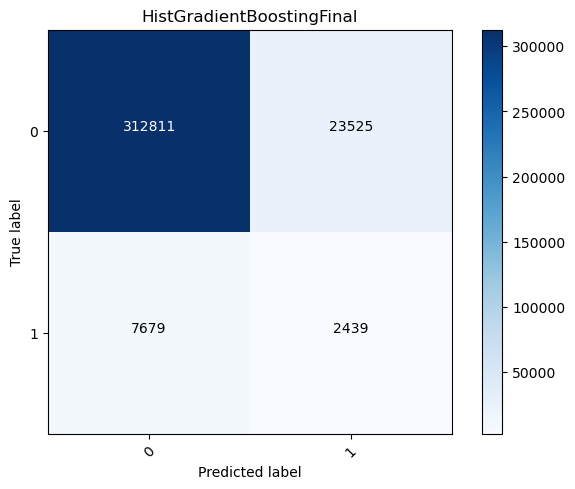

In [70]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
cl = (probs_val > thr).astype(int)    
plot_confusion_matrix(confusion_matrix(test_y, cl), classes=['0','1'], title='HistGradientBoostingFinal')
print('точность:', precision_score(test_y, cl))
print('полнота:', recall_score(test_y, cl))

# 5. Results

Лучше всего себя показала модель HistGradientBoosting. Результаты получились улучшить, за счет дополнительного подбора параметров. Определить влияние фичей на предсказание для выбранной модели не представляется возможным, т.к. модель относится к решающим деревьям классификации. Также были опробованы другие модели, но они отличались очень слабой производительностью для представленных данных, поэтому в работе не отображены.

Обучим модель на всех данных

In [73]:
all_data = pd.concat([train, test])
all_data

,target,visit_time_std,visit_number_std,device_screen_resolution_std,day_std,day_of_week_std,month_std,utm_source_BKeImrJuRDZcHiSSTdzm,utm_source_CFeqZLBNQdYHxJrTOHjY,utm_source_CgsxHpdTmXHvrHqEKRxp,...,geo_city_Zarechnyy,geo_city_Zheleznodorozhny,geo_city_Zheleznogorsk,geo_city_Zhukovskiy,geo_city_Zlatoust,geo_city_Zurich,geo_city_Zvenigorod,geo_city_other,geo_city_Тимофеевка,geo_city_Хомутово
696475,0,-0.426173,0.570199,-0.342907,0.671939,1.110080,0.325346,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1732601,0,-0.589254,0.570199,-0.342907,1.127070,1.110080,0.778167,0,0,0,...,0,0,0,0,0,0,0,0,0,0
136315,0,-0.100011,0.570199,2.446721,1.013287,-0.399717,-1.938754,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1418650,0,0.063070,0.570199,-0.504167,-0.921020,0.103549,1.230987,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1664031,0,-0.752336,0.570199,-0.472996,1.582201,-1.406249,-1.938754,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346449,0,-0.589254,0.570199,2.114227,1.013287,1.110080,-1.485934,0,0,0,...,0,0,0,0,0,0,0,0,0,0
346450,0,-0.426173,-1.453579,-0.342907,-1.603716,1.110080,-1.033114,0,0,0,...,0,0,0,0,0,0,0,0,0,0
346451,0,1.530800,0.570199,-0.545729,0.785722,-0.399717,0.778167,0,0,0,...,0,0,0,0,0,0,0,0,0,0
346452,0,0.226151,-1.828353,0.635735,1.127070,0.606815,-0.580294,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
x = all_data.drop(columns = ['target'])
y = all_data['target']

In [75]:
# Обучение на всех данных
hgbc_final = HistGradientBoostingClassifier(l2_regularization= 10, learning_rate= 0.2, loss= 'binary_crossentropy', 
                                      max_depth= 10, max_iter= 200, max_leaf_nodes= 26, min_samples_leaf= 10)
hgbc_final.fit(x, y)

HistGradientBoostingClassifier(l2_regularization=10, learning_rate=0.2,
                               loss='binary_crossentropy', max_depth=10,
                               max_iter=200, max_leaf_nodes=26,
                               min_samples_leaf=10)

In [76]:
# Подготовим модель к передаче
filename = "final_kurs_pickle.pickle"

with open(filename, 'wb') as file:
    pickle.dump(hgbc_final, file)